### Imports

In [ ]:
pip install -q lovely-tensors tensorboard wandb datasets


In [ ]:
pip install -r requirements.txt
#pip freeze > requirements.txt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import io

import wandb
import numpy as np
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support, f1_score, precision_score, recall_score, confusion_matrix

from tqdm.notebook import tqdm

### Loading and transforming data

Alzheimer MRI Disease Classification dataset ([Hugging face link](https://huggingface.co/datasets/Falah/Alzheimer_MRI)) that focuses on the classification of early sympthoms of Alzheimer's disease based on MRI scans.

- Number of examples in train: 5120
- Number of examples in test: 1280

In [3]:
# create PyTorch dataset
class AlzheimerDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']

        # Convert PIL image to RGB mode if it's not already
        if image.mode != 'RGB':
            image = image.convert('RGB')

        label = self.dataset[idx]['label']

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# transform to tensor and normalise
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# load data
data_train = load_dataset('Falah/Alzheimer_MRI', split='train')
data_test = load_dataset('Falah/Alzheimer_MRI', split='test')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

In [6]:
# transform data and define dataloaders
train_dataset = AlzheimerDataset(data_train, transform=transform)
test_dataset = AlzheimerDataset(data_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Analyzing data

In [ ]:
# Data Analysis Functions
def analyze_class_distribution(dataset):
    labels = [sample['label'] for sample in dataset]
    unique_labels, counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=unique_labels, y=counts)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

    return dict(zip(unique_labels, counts))

def show_sample_images(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(dataset[i]['image'])
        axes[i].set_title(f"Class: {dataset[i]['label']}")
        axes[i].axis('off')
    plt.show()

The dataset consists of brain MRI images labeled into four categories:

- 0: Mild_Demented - start of Alzheimer's
- 1: Moderate_Demented - early progression of Alzheimer's
- 2: Non_Demented - healthy brain
- 3: Very_Mild_Demented - prerequisites to Alzheimer's


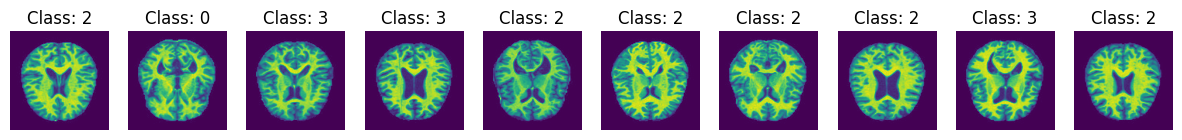

In [ ]:
show_sample_images(data_train, 10)

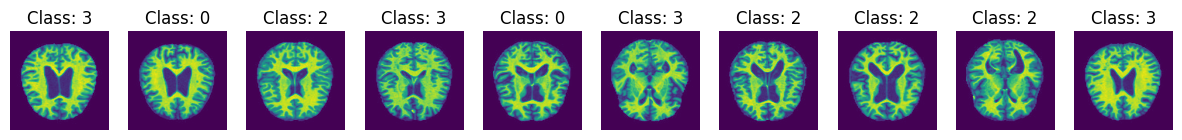

In [ ]:
show_sample_images(data_test, 10)

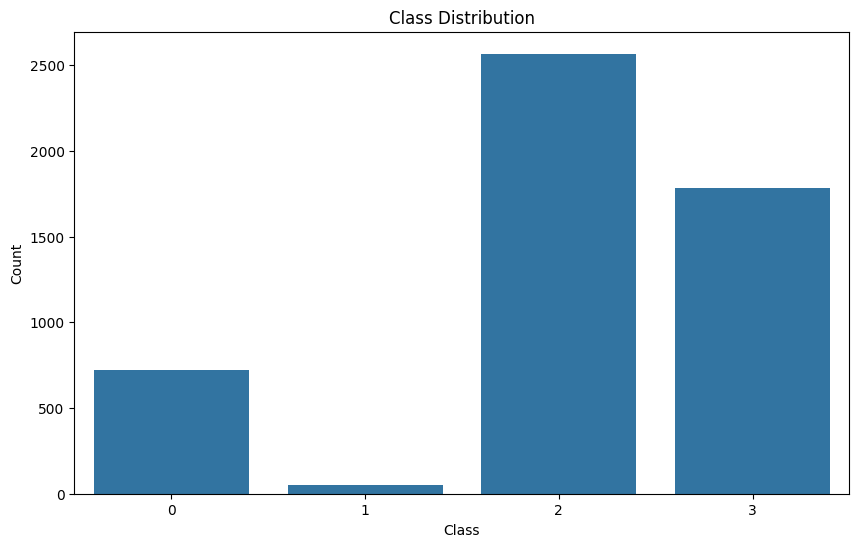

{0: 724, 1: 49, 2: 2566, 3: 1781}

In [ ]:
analyze_class_distribution(data_train)

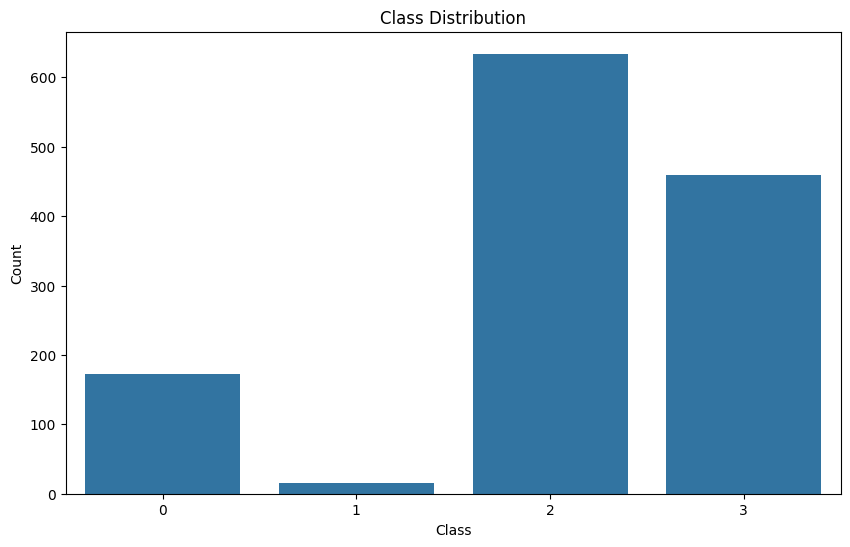

{0: 172, 1: 15, 2: 634, 3: 459}

In [ ]:
analyze_class_distribution(data_test)

The class imbalance is quite high, however, if we learn to predict second class (healthy brain) with high precision, we can consider model successfull regardless of the lower quality of other classes. In medical area of research precision plays a bigger role if we are talking about positive (health) classes and recall is more important when we talk about negative (disease) classes. The inbetween can be managed by patient's examination, while missing a disease can turn out lethal.

We see that train and test data is well split and ensures the same distribution of classes.

### Buliding CNN model baseline

In [7]:
# Model Definition
class AlzheimerCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(AlzheimerCNN, self).__init__()
        # Use ResNet50 as backbone
        self.resnet = models.resnet50(pretrained=True)

        # Replace final layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

### Evaluation setup

In [8]:
# Calculate per-class and overall metrics

def calculate_metrics(y_true, y_pred, num_classes=4):
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    precision_overall = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall_overall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1_overall = f1_score(y_true, y_pred, average='macro', zero_division=0)

    metrics = {
        'overall_precision': precision_overall,
        'overall_recall': recall_overall,
        'overall_f1': f1_overall,
    }

    for i in range(num_classes):
        metrics.update({
            f'class_{i}_precision': precision_per_class[i],
            f'class_{i}_recall': recall_per_class[i],
            f'class_{i}_f1': f1_per_class[i],
        })

    return metrics

In [9]:
# Plot confusion matrix and return the figure

def plot_confusion_matrix(y_true, y_pred, class_names=None):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names if class_names else "auto",
                yticklabels=class_names if class_names else "auto")
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    plt.close()
    buf.seek(0)

    return plt.gcf()

In [10]:
def validate_model(model, test_loader, device, epoch):
    """Perform validation and return detailed metrics"""
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Store predictions and targets
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate detailed metrics
    test_accuracy = 100. * correct / total
    metrics = calculate_metrics(all_targets, all_predictions)
    metrics['test_loss'] = test_loss / len(test_loader)
    metrics['test_accuracy'] = test_accuracy

    # Create and log confusion matrix
    class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
    cm_image = plot_confusion_matrix(all_targets, all_predictions, class_names)
    wandb.log({
        f"confusion_matrix_epoch_{epoch}": wandb.Image(cm_image)
    })
    cm = confusion_matrix(all_targets, all_predictions)
    print("\nConfusion Matrix:")
    print("Classes:", class_names)
    print(cm)

    # Calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for i, acc in enumerate(per_class_accuracy):
        metrics[f'class_{i}_accuracy'] = acc
        print(f"{class_names[i]} Accuracy: {acc:.3f}")

    return metrics

### Training CNN model

In [11]:
def train_model(model, train_loader, test_loader, num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0
        train_predictions = []
        train_targets = []

        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)

            # Store predictions and targets
            train_predictions.extend(predicted.cpu().numpy())
            train_targets.extend(targets.cpu().numpy())

        # Training metrics
        train_metrics = calculate_metrics(train_targets, train_predictions)
        train_metrics['train_loss'] = train_loss / len(train_loader)

        # Validation & logging all metrics to W&B
        val_metrics = validate_model(model, test_loader, device, epoch)
        metrics_to_log = {
            'epoch': epoch,
            # Training metrics
            'train_loss': train_metrics['train_loss'],
            'train_overall_f1': train_metrics['overall_f1'],
            'train_overall_precision': train_metrics['overall_precision'],
            'train_overall_recall': train_metrics['overall_recall'],
            # Validation metrics
            'test_loss': val_metrics['test_loss'],
            'test_accuracy': val_metrics['test_accuracy'],
            'test_overall_f1': val_metrics['overall_f1'],
            'test_overall_precision': val_metrics['overall_precision'],
            'test_overall_recall': val_metrics['overall_recall'],
        }

        # Per-class metrics
        for i in range(4):
            metrics_to_log.update({
                f'train_class_{i}_f1': train_metrics[f'class_{i}_f1'],
                f'train_class_{i}_precision': train_metrics[f'class_{i}_precision'],
                f'train_class_{i}_recall': train_metrics[f'class_{i}_recall'],
                f'test_class_{i}_f1': val_metrics[f'class_{i}_f1'],
                f'test_class_{i}_precision': val_metrics[f'class_{i}_precision'],
                f'test_class_{i}_recall': val_metrics[f'class_{i}_recall'],
            })

        wandb.log(metrics_to_log)

        # Print epoch summary
        print(f'\nEpoch: {epoch}')
        print(f'Training Metrics:')
        print(f'Loss: {train_metrics["train_loss"]:.3f}')
        print(f'Overall F1: {train_metrics["overall_f1"]:.3f}')
        print(f'Overall Precision: {train_metrics["overall_precision"]:.3f}')
        print(f'Overall Recall: {train_metrics["overall_recall"]:.3f}')

        print(f'\nValidation Metrics:')
        print(f'Loss: {val_metrics["test_loss"]:.3f}')
        print(f'Accuracy: {val_metrics["test_accuracy"]:.3f}%')
        print(f'Overall F1: {val_metrics["overall_f1"]:.3f}')
        print(f'Overall Precision: {val_metrics["overall_precision"]:.3f}')
        print(f'Overall Recall: {val_metrics["overall_recall"]:.3f}')

        # Print per-class metrics
        print('\nPer-class Validation Metrics:')
        for i in range(4):
            print(f'\nClass {i}:')
            print(f'F1: {val_metrics[f"class_{i}_f1"]:.3f}')
            print(f'Precision: {val_metrics[f"class_{i}_precision"]:.3f}')
            print(f'Recall: {val_metrics[f"class_{i}_recall"]:.3f}')

        scheduler.step(val_metrics['test_loss'])



### Validation of baseline (experiment 0)

In [ ]:
# Initialize W&B
wandb.init(project="alzheimer-classification", name="resnet50-experiment")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Initialize and train model
model = AlzheimerCNN()
train_model(model, train_loader, test_loader)

# Save model
torch.save(model.state_dict(), 'alzheimer_model.pth')
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 43   0  99  30]
 [  7   0   6   2]
 [ 26   0 579  29]
 [ 51   0 380  28]]
NonDemented Accuracy: 0.250
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.913
ModerateDemented Accuracy: 0.061

Epoch: 0
Training Metrics:
Loss: 0.933
Overall F1: 0.326
Overall Precision: 0.382
Overall Recall: 0.336

Validation Metrics:
Loss: 3.590
Accuracy: 50.781%
Overall F1: 0.268
Overall Precision: 0.299
Overall Recall: 0.306

Per-class Validation Metrics:

Class 0:
F1: 0.288
Precision: 0.339
Recall: 0.250

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.682
Precision: 0.544
Recall: 0.913

Class 3:
F1: 0.102
Precision: 0.315
Recall: 0.061


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 18   0  89  65]
 [  1   0   6   8]
 [  0   0 576  58]
 [  3   0 356 100]]
NonDemented Accuracy: 0.105
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.909
ModerateDemented Accuracy: 0.218

Epoch: 1
Training Metrics:
Loss: 0.844
Overall F1: 0.381
Overall Precision: 0.415
Overall Recall: 0.382

Validation Metrics:
Loss: 1.454
Accuracy: 54.219%
Overall F1: 0.292
Overall Precision: 0.453
Overall Recall: 0.308

Per-class Validation Metrics:

Class 0:
F1: 0.186
Precision: 0.818
Recall: 0.105

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.694
Precision: 0.561
Recall: 0.909

Class 3:
F1: 0.290
Precision: 0.433
Recall: 0.218


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[157   0   1  14]
 [ 15   0   0   0]
 [165   0 332 137]
 [253   0  34 172]]
NonDemented Accuracy: 0.913
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.524
ModerateDemented Accuracy: 0.375

Epoch: 2
Training Metrics:
Loss: 0.774
Overall F1: 0.441
Overall Precision: 0.447
Overall Recall: 0.440

Validation Metrics:
Loss: 0.911
Accuracy: 51.641%
Overall F1: 0.379
Overall Precision: 0.426
Overall Recall: 0.453

Per-class Validation Metrics:

Class 0:
F1: 0.412
Precision: 0.266
Recall: 0.913

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.663
Precision: 0.905
Recall: 0.524

Class 3:
F1: 0.440
Precision: 0.533
Recall: 0.375


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 10   0 135  27]
 [  0   0  13   2]
 [  3   0 625   6]
 [  1   0 430  28]]
NonDemented Accuracy: 0.058
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.986
ModerateDemented Accuracy: 0.061

Epoch: 3
Training Metrics:
Loss: 0.729
Overall F1: 0.485
Overall Precision: 0.488
Overall Recall: 0.489

Validation Metrics:
Loss: 2.735
Accuracy: 51.797%
Overall F1: 0.224
Overall Precision: 0.420
Overall Recall: 0.276

Per-class Validation Metrics:

Class 0:
F1: 0.108
Precision: 0.714
Recall: 0.058

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.680
Precision: 0.520
Recall: 0.986

Class 3:
F1: 0.107
Precision: 0.444
Recall: 0.061


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 92   0   7  73]
 [  6   0   3   6]
 [ 12   0 482 140]
 [ 15   0  70 374]]
NonDemented Accuracy: 0.535
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.760
ModerateDemented Accuracy: 0.815

Epoch: 4
Training Metrics:
Loss: 0.612
Overall F1: 0.549
Overall Precision: 0.543
Overall Recall: 0.559

Validation Metrics:
Loss: 0.662
Accuracy: 74.062%
Overall F1: 0.534
Overall Precision: 0.556
Overall Recall: 0.527

Per-class Validation Metrics:

Class 0:
F1: 0.620
Precision: 0.736
Recall: 0.535

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.806
Precision: 0.858
Recall: 0.760

Class 3:
F1: 0.711
Precision: 0.631
Recall: 0.815


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[119   0   1  52]
 [ 12   0   1   2]
 [ 21   0 235 378]
 [ 17   0   3 439]]
NonDemented Accuracy: 0.692
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.371
ModerateDemented Accuracy: 0.956

Epoch: 5
Training Metrics:
Loss: 0.523
Overall F1: 0.596
Overall Precision: 0.587
Overall Recall: 0.608

Validation Metrics:
Loss: 0.890
Accuracy: 61.953%
Overall F1: 0.474
Overall Precision: 0.547
Overall Recall: 0.505

Per-class Validation Metrics:

Class 0:
F1: 0.698
Precision: 0.704
Recall: 0.692

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.538
Precision: 0.979
Recall: 0.371

Class 3:
F1: 0.660
Precision: 0.504
Recall: 0.956


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[134   0  26  12]
 [ 10   0   3   2]
 [ 11   0 601  22]
 [ 15   0 226 218]]
NonDemented Accuracy: 0.779
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.948
ModerateDemented Accuracy: 0.475

Epoch: 6
Training Metrics:
Loss: 0.413
Overall F1: 0.633
Overall Precision: 0.623
Overall Recall: 0.645

Validation Metrics:
Loss: 0.642
Accuracy: 74.453%
Overall F1: 0.550
Overall Precision: 0.587
Overall Recall: 0.550

Per-class Validation Metrics:

Class 0:
F1: 0.784
Precision: 0.788
Recall: 0.779

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.807
Precision: 0.702
Recall: 0.948

Class 3:
F1: 0.612
Precision: 0.858
Recall: 0.475


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 86   0  21  65]
 [  4   0   7   4]
 [  1   0 581  52]
 [  1   0  35 423]]
NonDemented Accuracy: 0.500
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.916
ModerateDemented Accuracy: 0.922

Epoch: 7
Training Metrics:
Loss: 0.317
Overall F1: 0.661
Overall Precision: 0.652
Overall Recall: 0.671

Validation Metrics:
Loss: 0.459
Accuracy: 85.156%
Overall F1: 0.601
Overall Precision: 0.654
Overall Recall: 0.584

Per-class Validation Metrics:

Class 0:
F1: 0.652
Precision: 0.935
Recall: 0.500

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.909
Precision: 0.902
Recall: 0.916

Class 3:
F1: 0.843
Precision: 0.778
Recall: 0.922


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[150   0   8  14]
 [ 11   0   0   4]
 [ 25   0 540  69]
 [ 18   0  24 417]]
NonDemented Accuracy: 0.872
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.852
ModerateDemented Accuracy: 0.908

Epoch: 8
Training Metrics:
Loss: 0.242
Overall F1: 0.690
Overall Precision: 0.682
Overall Recall: 0.698

Validation Metrics:
Loss: 0.360
Accuracy: 86.484%
Overall F1: 0.640
Overall Precision: 0.627
Overall Recall: 0.658

Per-class Validation Metrics:

Class 0:
F1: 0.798
Precision: 0.735
Recall: 0.872

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.896
Precision: 0.944
Recall: 0.852

Class 3:
F1: 0.866
Precision: 0.827
Recall: 0.908


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[158   0   6   8]
 [ 12   0   3   0]
 [ 24   0 594  16]
 [ 33   0  55 371]]
NonDemented Accuracy: 0.919
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.937
ModerateDemented Accuracy: 0.808

Epoch: 9
Training Metrics:
Loss: 0.179
Overall F1: 0.706
Overall Precision: 0.699
Overall Recall: 0.713

Validation Metrics:
Loss: 0.362
Accuracy: 87.734%
Overall F1: 0.645
Overall Precision: 0.635
Overall Recall: 0.666

Per-class Validation Metrics:

Class 0:
F1: 0.792
Precision: 0.696
Recall: 0.919

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.920
Precision: 0.903
Recall: 0.937

Class 3:
F1: 0.869
Precision: 0.939
Recall: 0.808


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁▂▁▁▅▃▅███
test_class_0_f1,▃▂▄▁▆▇█▇██
test_class_0_precision,▂▇▁▆▆▆▆█▆▆
test_class_0_recall,▃▁█▁▅▆▇▅██
test_class_1_f1,▁▁▁▁▁▁▁▁▁▁
test_class_1_precision,▁▁▁▁▁▁▁▁▁▁
test_class_1_recall,▁▁▁▁▁▁▁▁▁▁
test_class_2_f1,▄▄▃▄▆▁▆███
test_class_2_precision,▁▂▇▁▆█▄▇▇▇
test_class_2_recall,▇▇▃█▅▁█▇▆▇


<Figure size 640x480 with 0 Axes>

### Experiments

#### 1. Data Augmentation



In [12]:
# Create separate transformation functions for train and test data

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
train_dataset_1 = AlzheimerDataset(data_train, transform=train_transform)
test_dataset_1 = AlzheimerDataset(data_test, transform=test_transform)

train_loader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True)
test_loader_1 = DataLoader(test_dataset_1, batch_size=32, shuffle=False)

In [15]:
# Initialize W&B
wandb.init(project="alzheimer-classification", name="resnet50-experiment_1")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [16]:
# Initialize and train model
model = AlzheimerCNN()
train_model(model, train_loader_1, test_loader_1)

# Save model
torch.save(model.state_dict(), 'alzheimer_model_1.pth')
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 35   0  43  94]
 [  4   0   2   9]
 [ 14   0 488 132]
 [ 28   0 244 187]]
NonDemented Accuracy: 0.203
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.770
ModerateDemented Accuracy: 0.407

Epoch: 0
Training Metrics:
Loss: 0.985
Overall F1: 0.301
Overall Precision: 0.342
Overall Recall: 0.309

Validation Metrics:
Loss: 0.902
Accuracy: 55.469%
Overall F1: 0.348
Overall Precision: 0.376
Overall Recall: 0.345

Per-class Validation Metrics:

Class 0:
F1: 0.277
Precision: 0.432
Recall: 0.203

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.692
Precision: 0.628
Recall: 0.770

Class 3:
F1: 0.425
Precision: 0.443
Recall: 0.407


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 34   0  17 121]
 [  3   0   0  12]
 [ 15   0 459 160]
 [ 21   0 220 218]]
NonDemented Accuracy: 0.198
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.724
ModerateDemented Accuracy: 0.475

Epoch: 1
Training Metrics:
Loss: 0.892
Overall F1: 0.345
Overall Precision: 0.372
Overall Recall: 0.345

Validation Metrics:
Loss: 0.890
Accuracy: 55.547%
Overall F1: 0.354
Overall Precision: 0.388
Overall Recall: 0.349

Per-class Validation Metrics:

Class 0:
F1: 0.278
Precision: 0.466
Recall: 0.198

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.690
Precision: 0.659
Recall: 0.724

Class 3:
F1: 0.449
Precision: 0.427
Recall: 0.475


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[108   0   7  57]
 [ 13   0   0   2]
 [ 83   0 413 138]
 [134   0 142 183]]
NonDemented Accuracy: 0.628
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.651
ModerateDemented Accuracy: 0.399

Epoch: 2
Training Metrics:
Loss: 0.869
Overall F1: 0.345
Overall Precision: 0.377
Overall Recall: 0.348

Validation Metrics:
Loss: 0.942
Accuracy: 55.000%
Overall F1: 0.388
Overall Precision: 0.384
Overall Recall: 0.420

Per-class Validation Metrics:

Class 0:
F1: 0.424
Precision: 0.320
Recall: 0.628

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.691
Precision: 0.735
Recall: 0.651

Class 3:
F1: 0.436
Precision: 0.482
Recall: 0.399


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 76   0  47  49]
 [ 10   0   0   5]
 [ 46   0 530  58]
 [ 90   0 297  72]]
NonDemented Accuracy: 0.442
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.836
ModerateDemented Accuracy: 0.157

Epoch: 3
Training Metrics:
Loss: 0.865
Overall F1: 0.360
Overall Precision: 0.387
Overall Recall: 0.359

Validation Metrics:
Loss: 1.162
Accuracy: 52.969%
Overall F1: 0.328
Overall Precision: 0.335
Overall Recall: 0.359

Per-class Validation Metrics:

Class 0:
F1: 0.386
Precision: 0.342
Recall: 0.442

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.703
Precision: 0.606
Recall: 0.836

Class 3:
F1: 0.224
Precision: 0.391
Recall: 0.157


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[  0   0  14 158]
 [  0   0   0  15]
 [  0   0 458 176]
 [  0   0 201 258]]
NonDemented Accuracy: 0.000
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.722
ModerateDemented Accuracy: 0.562

Epoch: 4
Training Metrics:
Loss: 0.843
Overall F1: 0.371
Overall Precision: 0.389
Overall Recall: 0.367

Validation Metrics:
Loss: 0.900
Accuracy: 55.938%
Overall F1: 0.296
Overall Precision: 0.276
Overall Recall: 0.321

Per-class Validation Metrics:

Class 0:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.701
Precision: 0.681
Recall: 0.722

Class 3:
F1: 0.484
Precision: 0.425
Recall: 0.562


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 15   0   7 150]
 [  1   0   0  14]
 [  1   0 422 211]
 [  7   0 140 312]]
NonDemented Accuracy: 0.087
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.666
ModerateDemented Accuracy: 0.680

Epoch: 5
Training Metrics:
Loss: 0.828
Overall F1: 0.324
Overall Precision: 0.427
Overall Recall: 0.348

Validation Metrics:
Loss: 0.808
Accuracy: 58.516%
Overall F1: 0.350
Overall Precision: 0.455
Overall Recall: 0.358

Per-class Validation Metrics:

Class 0:
F1: 0.153
Precision: 0.625
Recall: 0.087

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.702
Precision: 0.742
Recall: 0.666

Class 3:
F1: 0.545
Precision: 0.454
Recall: 0.680


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 52   0   7 113]
 [  5   0   0  10]
 [ 17   0 440 177]
 [ 35   0 163 261]]
NonDemented Accuracy: 0.302
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.694
ModerateDemented Accuracy: 0.569

Epoch: 6
Training Metrics:
Loss: 0.794
Overall F1: 0.372
Overall Precision: 0.424
Overall Recall: 0.373

Validation Metrics:
Loss: 0.799
Accuracy: 58.828%
Overall F1: 0.397
Overall Precision: 0.416
Overall Recall: 0.391

Per-class Validation Metrics:

Class 0:
F1: 0.370
Precision: 0.477
Recall: 0.302

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.707
Precision: 0.721
Recall: 0.694

Class 3:
F1: 0.512
Precision: 0.465
Recall: 0.569


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 74   0   3  95]
 [  6   0   0   9]
 [ 23   0 401 210]
 [ 49   0  88 322]]
NonDemented Accuracy: 0.430
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.632
ModerateDemented Accuracy: 0.702

Epoch: 7
Training Metrics:
Loss: 0.782
Overall F1: 0.414
Overall Precision: 0.431
Overall Recall: 0.410

Validation Metrics:
Loss: 0.787
Accuracy: 62.266%
Overall F1: 0.439
Overall Precision: 0.452
Overall Recall: 0.441

Per-class Validation Metrics:

Class 0:
F1: 0.457
Precision: 0.487
Recall: 0.430

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.712
Precision: 0.815
Recall: 0.632

Class 3:
F1: 0.588
Precision: 0.506
Recall: 0.702


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 85   0   5  82]
 [  9   0   0   6]
 [ 22   0 430 182]
 [ 49   0 128 282]]
NonDemented Accuracy: 0.494
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.678
ModerateDemented Accuracy: 0.614

Epoch: 8
Training Metrics:
Loss: 0.775
Overall F1: 0.425
Overall Precision: 0.437
Overall Recall: 0.424

Validation Metrics:
Loss: 0.772
Accuracy: 62.266%
Overall F1: 0.445
Overall Precision: 0.447
Overall Recall: 0.447

Per-class Validation Metrics:

Class 0:
F1: 0.504
Precision: 0.515
Recall: 0.494

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.718
Precision: 0.764
Recall: 0.678

Class 3:
F1: 0.558
Precision: 0.511
Recall: 0.614


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 78   0   8  86]
 [  7   0   0   8]
 [ 24   0 454 156]
 [ 51   0 159 249]]
NonDemented Accuracy: 0.453
VeryMildDemented Accuracy: 0.000
MildDemented Accuracy: 0.716
ModerateDemented Accuracy: 0.542

Epoch: 9
Training Metrics:
Loss: 0.757
Overall F1: 0.438
Overall Precision: 0.445
Overall Recall: 0.437

Validation Metrics:
Loss: 0.768
Accuracy: 61.016%
Overall F1: 0.428
Overall Precision: 0.429
Overall Recall: 0.428

Per-class Validation Metrics:

Class 0:
F1: 0.470
Precision: 0.487
Recall: 0.453

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.724
Precision: 0.731
Recall: 0.716

Class 3:
F1: 0.520
Precision: 0.499
Recall: 0.542


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▃▃▃▁▃▅▅██▇
test_class_0_f1,▅▅▇▆▁▃▆▇██
test_class_0_precision,▆▆▅▅▁█▆▆▇▆
test_class_0_recall,▃▃█▆▁▂▄▆▇▆
test_class_1_f1,▁▁▁▁▁▁▁▁▁▁
test_class_1_precision,▁▁▁▁▁▁▁▁▁▁
test_class_1_recall,▁▁▁▁▁▁▁▁▁▁
test_class_2_f1,▁▁▁▄▃▃▅▆▇█
test_class_2_precision,▂▃▅▁▃▆▅█▆▅
test_class_2_recall,▆▄▂█▄▂▃▁▃▄


<Figure size 640x480 with 0 Axes>

#### 2. Balanced Sampling

In [ ]:
from torch.utils.data import WeightedRandomSampler

def create_balanced_sampler(dataset):
    labels = [sample['label'] for sample in dataset]
    class_counts = torch.bincount(torch.tensor(labels))
    weight_per_class = 1. / class_counts.float()
    weights = [weight_per_class[label] for label in labels]
    sampler = WeightedRandomSampler(weights, len(weights))
    return sampler

# Use in DataLoader
train_loader_2 = DataLoader(
    train_dataset_1,
    batch_size=32,
    sampler=create_balanced_sampler(data_train)
)

In [ ]:
# Initialize W&B
wandb.init(project="alzheimer-classification", name="resnet50-experiment_2")

wandb: Currently logged in as: milfey (milfey21). Use `wandb login --relogin` to force relogin


In [ ]:
# Initialize and train model
model = AlzheimerCNN()
train_model(model, train_loader_2, test_loader_1)

# Save model
torch.save(model.state_dict(), 'alzheimer_model_2.pth')
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 0
Training Metrics:
Loss: 1.121
Overall F1: 0.472
Overall Precision: 0.470
Overall Recall: 0.480

Validation Metrics:
Loss: 1.818
Accuracy: 49.922%
Overall F1: 0.175
Overall Precision: 0.193
Overall Recall: 0.253

Per-class Validation Metrics:

Class 0:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 1:
F1: 0.000
Precision: 0.000
Recall: 0.000

Class 2:
F1: 0.669
Precision: 0.504
Recall: 0.997

Class 3:
F1: 0.029
Precision: 0.269
Recall: 0.015


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 1
Training Metrics:
Loss: 0.834
Overall F1: 0.607
Overall Precision: 0.604
Overall Recall: 0.616

Validation Metrics:
Loss: 3.367
Accuracy: 31.641%
Overall F1: 0.260
Overall Precision: 0.369
Overall Recall: 0.452

Per-class Validation Metrics:

Class 0:
F1: 0.203
Precision: 0.187
Recall: 0.221

Class 1:
F1: 0.049
Precision: 0.025
Recall: 1.000

Class 2:
F1: 0.606
Precision: 0.854
Recall: 0.470

Class 3:
F1: 0.183
Precision: 0.409
Recall: 0.118


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 2
Training Metrics:
Loss: 0.761
Overall F1: 0.625
Overall Precision: 0.626
Overall Recall: 0.640

Validation Metrics:
Loss: 4.766
Accuracy: 11.953%
Overall F1: 0.128
Overall Precision: 0.306
Overall Recall: 0.371

Per-class Validation Metrics:

Class 0:
F1: 0.261
Precision: 0.204
Recall: 0.360

Class 1:
F1: 0.034
Precision: 0.017
Recall: 1.000

Class 2:
F1: 0.204
Precision: 0.880
Recall: 0.115

Class 3:
F1: 0.012
Precision: 0.125
Recall: 0.007


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 3
Training Metrics:
Loss: 0.724
Overall F1: 0.646
Overall Precision: 0.646
Overall Recall: 0.655

Validation Metrics:
Loss: 1.069
Accuracy: 50.625%
Overall F1: 0.547
Overall Precision: 0.642
Overall Recall: 0.605

Per-class Validation Metrics:

Class 0:
F1: 0.392
Precision: 0.252
Recall: 0.878

Class 1:
F1: 0.846
Precision: 1.000
Recall: 0.733

Class 2:
F1: 0.706
Precision: 0.768
Recall: 0.653

Class 3:
F1: 0.244
Precision: 0.550
Recall: 0.157


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 4
Training Metrics:
Loss: 0.709
Overall F1: 0.661
Overall Precision: 0.663
Overall Recall: 0.670

Validation Metrics:
Loss: 1.411
Accuracy: 42.969%
Overall F1: 0.474
Overall Precision: 0.644
Overall Recall: 0.522

Per-class Validation Metrics:

Class 0:
F1: 0.370
Precision: 0.229
Recall: 0.953

Class 1:
F1: 0.636
Precision: 1.000
Recall: 0.467

Class 2:
F1: 0.572
Precision: 0.920
Recall: 0.415

Class 3:
F1: 0.317
Precision: 0.426
Recall: 0.253


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 5
Training Metrics:
Loss: 0.694
Overall F1: 0.670
Overall Precision: 0.673
Overall Recall: 0.674

Validation Metrics:
Loss: 0.949
Accuracy: 51.953%
Overall F1: 0.455
Overall Precision: 0.474
Overall Recall: 0.671

Per-class Validation Metrics:

Class 0:
F1: 0.427
Precision: 0.284
Recall: 0.860

Class 1:
F1: 0.492
Precision: 0.326
Recall: 1.000

Class 2:
F1: 0.719
Precision: 0.726
Recall: 0.713

Class 3:
F1: 0.182
Precision: 0.562
Recall: 0.109


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 6
Training Metrics:
Loss: 0.682
Overall F1: 0.674
Overall Precision: 0.682
Overall Recall: 0.676

Validation Metrics:
Loss: 0.875
Accuracy: 56.328%
Overall F1: 0.525
Overall Precision: 0.498
Overall Recall: 0.692

Per-class Validation Metrics:

Class 0:
F1: 0.442
Precision: 0.317
Recall: 0.733

Class 1:
F1: 0.484
Precision: 0.319
Recall: 1.000

Class 2:
F1: 0.693
Precision: 0.814
Recall: 0.603

Class 3:
F1: 0.480
Precision: 0.541
Recall: 0.431


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 7
Training Metrics:
Loss: 0.654
Overall F1: 0.687
Overall Precision: 0.694
Overall Recall: 0.689

Validation Metrics:
Loss: 1.278
Accuracy: 41.641%
Overall F1: 0.502
Overall Precision: 0.616
Overall Recall: 0.576

Per-class Validation Metrics:

Class 0:
F1: 0.358
Precision: 0.219
Recall: 0.971

Class 1:
F1: 0.846
Precision: 1.000
Recall: 0.733

Class 2:
F1: 0.595
Precision: 0.858
Recall: 0.456

Class 3:
F1: 0.210
Precision: 0.388
Recall: 0.144


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 8
Training Metrics:
Loss: 0.662
Overall F1: 0.687
Overall Precision: 0.694
Overall Recall: 0.689

Validation Metrics:
Loss: 1.107
Accuracy: 56.484%
Overall F1: 0.577
Overall Precision: 0.543
Overall Recall: 0.631

Per-class Validation Metrics:

Class 0:
F1: 0.410
Precision: 0.356
Recall: 0.483

Class 1:
F1: 0.757
Precision: 0.636
Recall: 0.933

Class 2:
F1: 0.687
Precision: 0.699
Recall: 0.675

Class 3:
F1: 0.454
Precision: 0.479
Recall: 0.431


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 9
Training Metrics:
Loss: 0.638
Overall F1: 0.701
Overall Precision: 0.708
Overall Recall: 0.702

Validation Metrics:
Loss: 1.094
Accuracy: 48.281%
Overall F1: 0.580
Overall Precision: 0.652
Overall Recall: 0.650

Per-class Validation Metrics:

Class 0:
F1: 0.409
Precision: 0.260
Recall: 0.965

Class 1:
F1: 0.929
Precision: 1.000
Recall: 0.867

Class 2:
F1: 0.630
Precision: 0.886
Recall: 0.489

Class 3:
F1: 0.350
Precision: 0.464
Recall: 0.281


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▇▄▁▇▆▇█▆█▇
test_class_0_f1,▁▄▅▇▇██▇▇▇
test_class_0_precision,▁▅▅▆▆▇▇▅█▆
test_class_0_recall,▁▃▄▇█▇▆█▄█
test_class_1_f1,▁▁▁▇▆▅▅▇▇█
test_class_1_precision,▁▁▁██▃▃█▅█
test_class_1_recall,▁██▆▄██▆█▇
test_class_2_f1,▇▆▁█▆██▆█▇
test_class_2_precision,▁▇▇▅█▅▆▇▄▇
test_class_2_recall,█▄▁▅▃▆▅▄▅▄


#### 3. EfficientNet-B2

Switched to EfficientNet-B2 + Selective layer freezing (better performance on medical images)

In [ ]:
class AlzheimerCNN_B2(nn.Module):
    def __init__(self, num_classes=4):
        super(AlzheimerCNN_B2, self).__init__()
        self.backbone = models.efficientnet_b2(pretrained=True)

        # Freeze early layers
        for param in list(self.backbone.parameters())[:-30]:
            param.requires_grad = False


    def forward(self, x):
        return self.backbone(x)

In [ ]:
# Initialize W&B
wandb.init(project="alzheimer-classification", name="resnet50-experiment_3")

In [ ]:
# Initialize and train model
model = AlzheimerCNN_B2()
train_model(model, train_loader_2, test_loader_1)

# Save model
torch.save(model.state_dict(), 'alzheimer_model_3.pth')
wandb.finish()

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 0
Training Metrics:
Loss: 1.315
Overall F1: 0.019
Overall Precision: 0.019
Overall Recall: 0.019

Validation Metrics:
Loss: 1.018
Accuracy: 51.562%
Overall F1: 0.474
Overall Precision: 0.473
Overall Recall: 0.581

Per-class Validation Metrics:

Class 0:
F1: 0.401
Precision: 0.273
Recall: 0.756

Class 1:
F1: 0.455
Precision: 0.345
Recall: 0.667

Class 2:
F1: 0.666
Precision: 0.731
Recall: 0.612

Class 3:
F1: 0.376
Precision: 0.543
Recall: 0.288


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 1
Training Metrics:
Loss: 0.905
Overall F1: 0.592
Overall Precision: 0.589
Overall Recall: 0.597

Validation Metrics:
Loss: 1.031
Accuracy: 51.016%
Overall F1: 0.478
Overall Precision: 0.500
Overall Recall: 0.620

Per-class Validation Metrics:

Class 0:
F1: 0.388
Precision: 0.419
Recall: 0.360

Class 1:
F1: 0.476
Precision: 0.312
Recall: 1.000

Class 2:
F1: 0.499
Precision: 0.840
Recall: 0.355

Class 3:
F1: 0.551
Precision: 0.430
Recall: 0.765


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 2
Training Metrics:
Loss: 0.831
Overall F1: 0.623
Overall Precision: 0.621
Overall Recall: 0.626

Validation Metrics:
Loss: 0.886
Accuracy: 59.219%
Overall F1: 0.583
Overall Precision: 0.541
Overall Recall: 0.708

Per-class Validation Metrics:

Class 0:
F1: 0.488
Precision: 0.373
Recall: 0.703

Class 1:
F1: 0.625
Precision: 0.455
Recall: 1.000

Class 2:
F1: 0.675
Precision: 0.778
Recall: 0.596

Class 3:
F1: 0.545
Precision: 0.558
Recall: 0.532


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 3
Training Metrics:
Loss: 0.788
Overall F1: 0.640
Overall Precision: 0.638
Overall Recall: 0.643

Validation Metrics:
Loss: 0.803
Accuracy: 62.031%
Overall F1: 0.661
Overall Precision: 0.659
Overall Recall: 0.676

Per-class Validation Metrics:

Class 0:
F1: 0.513
Precision: 0.528
Recall: 0.500

Class 1:
F1: 0.938
Precision: 0.882
Recall: 1.000

Class 2:
F1: 0.720
Precision: 0.655
Recall: 0.800

Class 3:
F1: 0.474
Precision: 0.571
Recall: 0.405


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 4
Training Metrics:
Loss: 0.752
Overall F1: 0.655
Overall Precision: 0.654
Overall Recall: 0.658

Validation Metrics:
Loss: 0.895
Accuracy: 56.328%
Overall F1: 0.586
Overall Precision: 0.565
Overall Recall: 0.657

Per-class Validation Metrics:

Class 0:
F1: 0.452
Precision: 0.335
Recall: 0.692

Class 1:
F1: 0.722
Precision: 0.619
Recall: 0.867

Class 2:
F1: 0.652
Precision: 0.788
Recall: 0.557

Class 3:
F1: 0.516
Precision: 0.518
Recall: 0.514


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 5
Training Metrics:
Loss: 0.718
Overall F1: 0.673
Overall Precision: 0.673
Overall Recall: 0.674

Validation Metrics:
Loss: 1.002
Accuracy: 53.828%
Overall F1: 0.518
Overall Precision: 0.506
Overall Recall: 0.695

Per-class Validation Metrics:

Class 0:
F1: 0.445
Precision: 0.310
Recall: 0.791

Class 1:
F1: 0.492
Precision: 0.326
Recall: 1.000

Class 2:
F1: 0.617
Precision: 0.859
Recall: 0.481

Class 3:
F1: 0.518
Precision: 0.530
Recall: 0.508


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 6
Training Metrics:
Loss: 0.703
Overall F1: 0.684
Overall Precision: 0.683
Overall Recall: 0.686

Validation Metrics:
Loss: 0.814
Accuracy: 62.188%
Overall F1: 0.593
Overall Precision: 0.546
Overall Recall: 0.705

Per-class Validation Metrics:

Class 0:
F1: 0.511
Precision: 0.439
Recall: 0.610

Class 1:
F1: 0.600
Precision: 0.429
Recall: 1.000

Class 2:
F1: 0.712
Precision: 0.738
Recall: 0.688

Class 3:
F1: 0.549
Precision: 0.578
Recall: 0.523


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 7
Training Metrics:
Loss: 0.669
Overall F1: 0.697
Overall Precision: 0.696
Overall Recall: 0.699

Validation Metrics:
Loss: 0.810
Accuracy: 61.094%
Overall F1: 0.649
Overall Precision: 0.620
Overall Recall: 0.721

Per-class Validation Metrics:

Class 0:
F1: 0.507
Precision: 0.384
Recall: 0.744

Class 1:
F1: 0.857
Precision: 0.750
Recall: 1.000

Class 2:
F1: 0.704
Precision: 0.751
Recall: 0.662

Class 3:
F1: 0.530
Precision: 0.595
Recall: 0.477


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 8
Training Metrics:
Loss: 0.651
Overall F1: 0.704
Overall Precision: 0.704
Overall Recall: 0.706

Validation Metrics:
Loss: 0.801
Accuracy: 61.953%
Overall F1: 0.645
Overall Precision: 0.612
Overall Recall: 0.731

Per-class Validation Metrics:

Class 0:
F1: 0.516
Precision: 0.387
Recall: 0.773

Class 1:
F1: 0.811
Precision: 0.682
Recall: 1.000

Class 2:
F1: 0.711
Precision: 0.763
Recall: 0.666

Class 3:
F1: 0.544
Precision: 0.618
Recall: 0.486


  0%|          | 0/160 [00:00<?, ?it/s]


Epoch: 9
Training Metrics:
Loss: 0.632
Overall F1: 0.711
Overall Precision: 0.710
Overall Recall: 0.714

Validation Metrics:
Loss: 0.823
Accuracy: 61.016%
Overall F1: 0.625
Overall Precision: 0.596
Overall Recall: 0.725

Per-class Validation Metrics:

Class 0:
F1: 0.540
Precision: 0.450
Recall: 0.674

Class 1:
F1: 0.714
Precision: 0.556
Recall: 1.000

Class 2:
F1: 0.632
Precision: 0.844
Recall: 0.505

Class 3:
F1: 0.614
Precision: 0.536
Recall: 0.719


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁▁▆█▄▃█▇█▇
test_class_0_f1,▂▁▆▇▄▄▇▆▇█
test_class_0_precision,▁▅▄█▃▂▆▄▄▆
test_class_0_recall,▇▁▇▃▆█▅▇█▆
test_class_1_f1,▁▁▃█▅▂▃▇▆▅
test_class_1_precision,▁▁▃█▅▁▂▆▆▄
test_class_1_recall,▁███▅█████
test_class_2_f1,▆▁▇█▆▅█▇█▅
test_class_2_precision,▄▇▅▁▆█▄▄▅▇
test_class_2_recall,▅▁▅█▄▃▆▆▆▃


#### 4. Advanced Classifier:

Multi-layer classifier with residual connections, batch normalization after each layer, progressive dropout (higher in early layers), and Xavier initialization for better convergence





In [ ]:
class AlzheimerCNN_B2_AC(nn.Module):
    def __init__(self, num_classes=4):
        super(AlzheimerCNN_B2_AC, self).__init__()

        # Use EfficientNet-B2 as backbone (better performance than ResNet for medical images)
        self.backbone = models.efficientnet_b2(pretrained=True)

        # Freeze early layers
        for param in list(self.backbone.parameters())[:-30]:
            param.requires_grad = False

        # Remove original classifier
        backbone_output_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()

        # Advanced classifier with residual connections
        self.classifier = nn.Sequential(
            nn.Linear(backbone_output_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, num_classes)
        )


    def forward(self, x):
        features = self.backbone.features(x)
        features = features.mean([2, 3])
        main_output = self.classifier(features)
        return main_output

In [ ]:
# Initialize W&B
wandb.init(project="alzheimer-classification", name="efficientnetb2-experiment_4")

In [ ]:
# Initialize and train model
model = AlzheimerCNN_B2_AC()
train_model(model, train_loader_2, test_loader_1)

# Save model
torch.save(model.state_dict(), 'alzheimer_model_4.pth')
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 90  38  38   6]
 [  2  11   1   1]
 [ 98  56 448  32]
 [120  81 218  40]]
NonDemented Accuracy: 0.523
VeryMildDemented Accuracy: 0.733
MildDemented Accuracy: 0.707
ModerateDemented Accuracy: 0.087

Epoch: 0
Training Metrics:
Loss: 1.096
Overall F1: 0.499
Overall Precision: 0.495
Overall Recall: 0.506

Validation Metrics:
Loss: 1.206
Accuracy: 46.016%
Overall F1: 0.325
Overall Precision: 0.373
Overall Recall: 0.513

Per-class Validation Metrics:

Class 0:
F1: 0.373
Precision: 0.290
Recall: 0.523

Class 1:
F1: 0.109
Precision: 0.059
Recall: 0.733

Class 2:
F1: 0.669
Precision: 0.635
Recall: 0.707

Class 3:
F1: 0.149
Precision: 0.506
Recall: 0.087


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[103  11  16  42]
 [  0  14   0   1]
 [ 76  17 345 196]
 [133  11 100 215]]
NonDemented Accuracy: 0.599
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.544
ModerateDemented Accuracy: 0.468

Epoch: 1
Training Metrics:
Loss: 0.911
Overall F1: 0.577
Overall Precision: 0.573
Overall Recall: 0.588

Validation Metrics:
Loss: 0.939
Accuracy: 52.891%
Overall F1: 0.485
Overall Precision: 0.454
Overall Recall: 0.636

Per-class Validation Metrics:

Class 0:
F1: 0.426
Precision: 0.330
Recall: 0.599

Class 1:
F1: 0.412
Precision: 0.264
Recall: 0.933

Class 2:
F1: 0.630
Precision: 0.748
Recall: 0.544

Class 3:
F1: 0.471
Precision: 0.474
Recall: 0.468


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[120  11  14  27]
 [  0  15   0   0]
 [146  19 356 113]
 [158  14 100 187]]
NonDemented Accuracy: 0.698
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.562
ModerateDemented Accuracy: 0.407

Epoch: 2
Training Metrics:
Loss: 0.829
Overall F1: 0.625
Overall Precision: 0.626
Overall Recall: 0.629

Validation Metrics:
Loss: 1.009
Accuracy: 52.969%
Overall F1: 0.482
Overall Precision: 0.467
Overall Recall: 0.667

Per-class Validation Metrics:

Class 0:
F1: 0.403
Precision: 0.283
Recall: 0.698

Class 1:
F1: 0.405
Precision: 0.254
Recall: 1.000

Class 2:
F1: 0.645
Precision: 0.757
Recall: 0.562

Class 3:
F1: 0.476
Precision: 0.572
Recall: 0.407


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[127  18  17  10]
 [  0  15   0   0]
 [132  19 400  83]
 [192  21 135 111]]
NonDemented Accuracy: 0.738
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.631
ModerateDemented Accuracy: 0.242

Epoch: 3
Training Metrics:
Loss: 0.806
Overall F1: 0.641
Overall Precision: 0.639
Overall Recall: 0.644

Validation Metrics:
Loss: 0.988
Accuracy: 51.016%
Overall F1: 0.439
Overall Precision: 0.439
Overall Recall: 0.653

Per-class Validation Metrics:

Class 0:
F1: 0.408
Precision: 0.282
Recall: 0.738

Class 1:
F1: 0.341
Precision: 0.205
Recall: 1.000

Class 2:
F1: 0.675
Precision: 0.725
Recall: 0.631

Class 3:
F1: 0.335
Precision: 0.544
Recall: 0.242


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[106   2  13  51]
 [  0  15   0   0]
 [ 68   9 369 188]
 [ 89   3 103 264]]
NonDemented Accuracy: 0.616
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.582
ModerateDemented Accuracy: 0.575

Epoch: 4
Training Metrics:
Loss: 0.767
Overall F1: 0.648
Overall Precision: 0.645
Overall Recall: 0.653

Validation Metrics:
Loss: 0.852
Accuracy: 58.906%
Overall F1: 0.594
Overall Precision: 0.551
Overall Recall: 0.693

Per-class Validation Metrics:

Class 0:
F1: 0.487
Precision: 0.403
Recall: 0.616

Class 1:
F1: 0.682
Precision: 0.517
Recall: 1.000

Class 2:
F1: 0.660
Precision: 0.761
Recall: 0.582

Class 3:
F1: 0.549
Precision: 0.525
Recall: 0.575


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[127   4   8  33]
 [  0  15   0   0]
 [102   9 328 195]
 [137   5  63 254]]
NonDemented Accuracy: 0.738
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.517
ModerateDemented Accuracy: 0.553

Epoch: 5
Training Metrics:
Loss: 0.735
Overall F1: 0.663
Overall Precision: 0.662
Overall Recall: 0.667

Validation Metrics:
Loss: 0.891
Accuracy: 56.562%
Overall F1: 0.568
Overall Precision: 0.538
Overall Recall: 0.702

Per-class Validation Metrics:

Class 0:
F1: 0.472
Precision: 0.347
Recall: 0.738

Class 1:
F1: 0.625
Precision: 0.455
Recall: 1.000

Class 2:
F1: 0.635
Precision: 0.822
Recall: 0.517

Class 3:
F1: 0.540
Precision: 0.527
Recall: 0.553


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[135   4   3  30]
 [  2  13   0   0]
 [125   4 244 261]
 [153   3  34 269]]
NonDemented Accuracy: 0.785
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.385
ModerateDemented Accuracy: 0.586

Epoch: 6
Training Metrics:
Loss: 0.734
Overall F1: 0.669
Overall Precision: 0.668
Overall Recall: 0.674

Validation Metrics:
Loss: 0.945
Accuracy: 51.641%
Overall F1: 0.547
Overall Precision: 0.554
Overall Recall: 0.656

Per-class Validation Metrics:

Class 0:
F1: 0.460
Precision: 0.325
Recall: 0.785

Class 1:
F1: 0.667
Precision: 0.542
Recall: 0.867

Class 2:
F1: 0.533
Precision: 0.868
Recall: 0.385

Class 3:
F1: 0.528
Precision: 0.480
Recall: 0.586


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 94   0  13  65]
 [  0  15   0   0]
 [ 47   0 377 210]
 [ 39   0 114 306]]
NonDemented Accuracy: 0.547
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.595
ModerateDemented Accuracy: 0.667

Epoch: 7
Training Metrics:
Loss: 0.695
Overall F1: 0.683
Overall Precision: 0.681
Overall Recall: 0.687

Validation Metrics:
Loss: 0.787
Accuracy: 61.875%
Overall F1: 0.696
Overall Precision: 0.699
Overall Recall: 0.702

Per-class Validation Metrics:

Class 0:
F1: 0.534
Precision: 0.522
Recall: 0.547

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.663
Precision: 0.748
Recall: 0.595

Class 3:
F1: 0.588
Precision: 0.527
Recall: 0.667


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[102   1   9  60]
 [  0  15   0   0]
 [ 40   1 296 297]
 [ 40   2  68 349]]
NonDemented Accuracy: 0.593
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.467
ModerateDemented Accuracy: 0.760

Epoch: 8
Training Metrics:
Loss: 0.709
Overall F1: 0.688
Overall Precision: 0.687
Overall Recall: 0.690

Validation Metrics:
Loss: 0.812
Accuracy: 59.531%
Overall F1: 0.661
Overall Precision: 0.659
Overall Recall: 0.705

Per-class Validation Metrics:

Class 0:
F1: 0.576
Precision: 0.560
Recall: 0.593

Class 1:
F1: 0.882
Precision: 0.789
Recall: 1.000

Class 2:
F1: 0.588
Precision: 0.794
Recall: 0.467

Class 3:
F1: 0.599
Precision: 0.494
Recall: 0.760


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[121   1   8  42]
 [  1  12   0   2]
 [ 63   0 342 229]
 [ 72   0  70 317]]
NonDemented Accuracy: 0.703
VeryMildDemented Accuracy: 0.800
MildDemented Accuracy: 0.539
ModerateDemented Accuracy: 0.691

Epoch: 9
Training Metrics:
Loss: 0.668
Overall F1: 0.698
Overall Precision: 0.696
Overall Recall: 0.701

Validation Metrics:
Loss: 0.789
Accuracy: 61.875%
Overall F1: 0.669
Overall Precision: 0.686
Overall Recall: 0.683

Per-class Validation Metrics:

Class 0:
F1: 0.564
Precision: 0.471
Recall: 0.703

Class 1:
F1: 0.857
Precision: 0.923
Recall: 0.800

Class 2:
F1: 0.649
Precision: 0.814
Recall: 0.539

Class 3:
F1: 0.604
Precision: 0.537
Recall: 0.691


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[125   3  22  22]
 [  0  15   0   0]
 [ 88   3 456  87]
 [ 94   3 164 198]]
NonDemented Accuracy: 0.727
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.719
ModerateDemented Accuracy: 0.431

Epoch: 10
Training Metrics:
Loss: 0.675
Overall F1: 0.700
Overall Precision: 0.699
Overall Recall: 0.703

Validation Metrics:
Loss: 0.786
Accuracy: 62.031%
Overall F1: 0.631
Overall Precision: 0.597
Overall Recall: 0.719

Per-class Validation Metrics:

Class 0:
F1: 0.522
Precision: 0.407
Recall: 0.727

Class 1:
F1: 0.769
Precision: 0.625
Recall: 1.000

Class 2:
F1: 0.715
Precision: 0.710
Recall: 0.719

Class 3:
F1: 0.517
Precision: 0.645
Recall: 0.431


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[150   0   7  15]
 [  0  15   0   0]
 [104   1 391 138]
 [112   4  99 244]]
NonDemented Accuracy: 0.872
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.617
ModerateDemented Accuracy: 0.532

Epoch: 11
Training Metrics:
Loss: 0.664
Overall F1: 0.707
Overall Precision: 0.707
Overall Recall: 0.709

Validation Metrics:
Loss: 0.788
Accuracy: 62.500%
Overall F1: 0.669
Overall Precision: 0.640
Overall Recall: 0.755

Per-class Validation Metrics:

Class 0:
F1: 0.558
Precision: 0.410
Recall: 0.872

Class 1:
F1: 0.857
Precision: 0.750
Recall: 1.000

Class 2:
F1: 0.691
Precision: 0.787
Recall: 0.617

Class 3:
F1: 0.570
Precision: 0.615
Recall: 0.532


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[107   0   8  57]
 [  0  15   0   0]
 [ 39   4 310 281]
 [ 37   0  57 365]]
NonDemented Accuracy: 0.622
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.489
ModerateDemented Accuracy: 0.795

Epoch: 12
Training Metrics:
Loss: 0.645
Overall F1: 0.717
Overall Precision: 0.716
Overall Recall: 0.718

Validation Metrics:
Loss: 0.772
Accuracy: 62.266%
Overall F1: 0.682
Overall Precision: 0.680
Overall Recall: 0.727

Per-class Validation Metrics:

Class 0:
F1: 0.603
Precision: 0.585
Recall: 0.622

Class 1:
F1: 0.882
Precision: 0.789
Recall: 1.000

Class 2:
F1: 0.614
Precision: 0.827
Recall: 0.489

Class 3:
F1: 0.628
Precision: 0.519
Recall: 0.795


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[143   1   8  20]
 [  0  15   0   0]
 [126   2 411  95]
 [143   0 118 198]]
NonDemented Accuracy: 0.831
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.648
ModerateDemented Accuracy: 0.431

Epoch: 13
Training Metrics:
Loss: 0.623
Overall F1: 0.722
Overall Precision: 0.722
Overall Recall: 0.725

Validation Metrics:
Loss: 0.846
Accuracy: 59.922%
Overall F1: 0.653
Overall Precision: 0.645
Overall Recall: 0.728

Per-class Validation Metrics:

Class 0:
F1: 0.490
Precision: 0.347
Recall: 0.831

Class 1:
F1: 0.909
Precision: 0.833
Recall: 1.000

Class 2:
F1: 0.702
Precision: 0.765
Recall: 0.648

Class 3:
F1: 0.513
Precision: 0.633
Recall: 0.431


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[118   2  10  42]
 [  1  14   0   0]
 [ 49   2 394 189]
 [ 43   1  99 316]]
NonDemented Accuracy: 0.686
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.621
ModerateDemented Accuracy: 0.688

Epoch: 14
Training Metrics:
Loss: 0.624
Overall F1: 0.723
Overall Precision: 0.723
Overall Recall: 0.726

Validation Metrics:
Loss: 0.719
Accuracy: 65.781%
Overall F1: 0.690
Overall Precision: 0.664
Overall Recall: 0.732

Per-class Validation Metrics:

Class 0:
F1: 0.616
Precision: 0.559
Recall: 0.686

Class 1:
F1: 0.824
Precision: 0.737
Recall: 0.933

Class 2:
F1: 0.693
Precision: 0.783
Recall: 0.621

Class 3:
F1: 0.628
Precision: 0.578
Recall: 0.688


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[129   1   8  34]
 [  0  15   0   0]
 [ 79   1 395 159]
 [ 66   0 107 286]]
NonDemented Accuracy: 0.750
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.623
ModerateDemented Accuracy: 0.623

Epoch: 15
Training Metrics:
Loss: 0.615
Overall F1: 0.723
Overall Precision: 0.724
Overall Recall: 0.726

Validation Metrics:
Loss: 0.723
Accuracy: 64.453%
Overall F1: 0.704
Overall Precision: 0.681
Overall Recall: 0.749

Per-class Validation Metrics:

Class 0:
F1: 0.578
Precision: 0.471
Recall: 0.750

Class 1:
F1: 0.938
Precision: 0.882
Recall: 1.000

Class 2:
F1: 0.691
Precision: 0.775
Recall: 0.623

Class 3:
F1: 0.610
Precision: 0.597
Recall: 0.623


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[127   4  12  29]
 [  0  15   0   0]
 [ 48   5 402 179]
 [ 55   2 118 284]]
NonDemented Accuracy: 0.738
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.634
ModerateDemented Accuracy: 0.619

Epoch: 16
Training Metrics:
Loss: 0.610
Overall F1: 0.732
Overall Precision: 0.731
Overall Recall: 0.734

Validation Metrics:
Loss: 0.725
Accuracy: 64.688%
Overall F1: 0.663
Overall Precision: 0.615
Overall Recall: 0.748

Per-class Validation Metrics:

Class 0:
F1: 0.632
Precision: 0.552
Recall: 0.738

Class 1:
F1: 0.732
Precision: 0.577
Recall: 1.000

Class 2:
F1: 0.690
Precision: 0.756
Recall: 0.634

Class 3:
F1: 0.597
Precision: 0.577
Recall: 0.619


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[143   1   5  23]
 [  0  15   0   0]
 [ 93   2 386 153]
 [ 96   0  97 266]]
NonDemented Accuracy: 0.831
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.609
ModerateDemented Accuracy: 0.580

Epoch: 17
Training Metrics:
Loss: 0.596
Overall F1: 0.747
Overall Precision: 0.746
Overall Recall: 0.748

Validation Metrics:
Loss: 0.777
Accuracy: 63.281%
Overall F1: 0.689
Overall Precision: 0.664
Overall Recall: 0.755

Per-class Validation Metrics:

Class 0:
F1: 0.567
Precision: 0.431
Recall: 0.831

Class 1:
F1: 0.909
Precision: 0.833
Recall: 1.000

Class 2:
F1: 0.688
Precision: 0.791
Recall: 0.609

Class 3:
F1: 0.590
Precision: 0.602
Recall: 0.580


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[133   1  10  28]
 [  0  15   0   0]
 [ 66   1 391 176]
 [ 52   0  91 316]]
NonDemented Accuracy: 0.773
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.617
ModerateDemented Accuracy: 0.688

Epoch: 18
Training Metrics:
Loss: 0.566
Overall F1: 0.756
Overall Precision: 0.755
Overall Recall: 0.758

Validation Metrics:
Loss: 0.693
Accuracy: 66.797%
Overall F1: 0.727
Overall Precision: 0.704
Overall Recall: 0.770

Per-class Validation Metrics:

Class 0:
F1: 0.629
Precision: 0.530
Recall: 0.773

Class 1:
F1: 0.938
Precision: 0.882
Recall: 1.000

Class 2:
F1: 0.694
Precision: 0.795
Recall: 0.617

Class 3:
F1: 0.646
Precision: 0.608
Recall: 0.688


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[126   1  10  35]
 [  0  15   0   0]
 [ 55   1 368 210]
 [ 39   0  79 341]]
NonDemented Accuracy: 0.733
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.580
ModerateDemented Accuracy: 0.743

Epoch: 19
Training Metrics:
Loss: 0.553
Overall F1: 0.759
Overall Precision: 0.760
Overall Recall: 0.760

Validation Metrics:
Loss: 0.674
Accuracy: 66.406%
Overall F1: 0.727
Overall Precision: 0.711
Overall Recall: 0.764

Per-class Validation Metrics:

Class 0:
F1: 0.643
Precision: 0.573
Recall: 0.733

Class 1:
F1: 0.938
Precision: 0.882
Recall: 1.000

Class 2:
F1: 0.675
Precision: 0.805
Recall: 0.580

Class 3:
F1: 0.653
Precision: 0.582
Recall: 0.743


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▃▃▃▅▅▃▆▆▆▆▇▆▆█▇▇▇██
test_class_0_f1,▁▂▂▂▄▄▃▅▆▆▅▆▇▄▇▆█▆██
test_class_0_precision,▁▂▁▁▄▃▂▇▇▅▄▄█▃▇▅▇▄▇█
test_class_0_recall,▁▃▄▅▃▅▆▁▂▅▅█▃▇▄▆▅▇▆▅
test_class_1_f1,▁▃▃▃▅▅▅█▇▇▆▇▇▇▇█▆▇██
test_class_1_precision,▁▃▂▂▄▄▅█▆▇▅▆▆▇▆▇▅▇▇▇
test_class_1_recall,▁▆████▅██▃████▆█████
test_class_2_f1,▆▅▅▆▆▅▁▆▃▅█▇▄█▇▇▇▇▇▆
test_class_2_precision,▁▄▅▄▅▇█▄▆▆▃▆▇▅▅▅▅▆▆▆
test_class_2_recall,█▄▅▆▅▄▁▅▃▄█▆▃▇▆▆▆▆▆▅


<Figure size 640x480 with 0 Axes>

#### 5. No data augmentation

In [ ]:
# Initialize W&B
wandb.init(project="alzheimer-classification", name="resnet50-experiment_5")

In [ ]:
train_loader_3 = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=create_balanced_sampler(data_train)
)

In [ ]:
# Initialize and train model
model = model = AlzheimerCNN_B2()
train_model(model, train_loader_3, test_loader)

# Save model
torch.save(model.state_dict(), 'alzheimer_model_5.pth')
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 176MB/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[ 97   0  28  47]
 [  0  12   0   3]
 [ 55   1 423 155]
 [ 40   2 111 306]]
NonDemented Accuracy: 0.564
VeryMildDemented Accuracy: 0.800
MildDemented Accuracy: 0.667
ModerateDemented Accuracy: 0.667

Epoch: 0
Training Metrics:
Loss: 0.988
Overall F1: 0.026
Overall Precision: 0.026
Overall Recall: 0.026

Validation Metrics:
Loss: 0.777
Accuracy: 65.469%
Overall F1: 0.668
Overall Precision: 0.664
Overall Recall: 0.674

Per-class Validation Metrics:

Class 0:
F1: 0.533
Precision: 0.505
Recall: 0.564

Class 1:
F1: 0.800
Precision: 0.800
Recall: 0.800

Class 2:
F1: 0.707
Precision: 0.753
Recall: 0.667

Class 3:
F1: 0.631
Precision: 0.599
Recall: 0.667


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[109   0  20  43]
 [  1  13   0   1]
 [ 53   0 392 189]
 [ 62   0  87 310]]
NonDemented Accuracy: 0.634
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.618
ModerateDemented Accuracy: 0.675

Epoch: 1
Training Metrics:
Loss: 0.582
Overall F1: 0.750
Overall Precision: 0.749
Overall Recall: 0.752

Validation Metrics:
Loss: 0.743
Accuracy: 64.375%
Overall F1: 0.697
Overall Precision: 0.710
Overall Recall: 0.699

Per-class Validation Metrics:

Class 0:
F1: 0.549
Precision: 0.484
Recall: 0.634

Class 1:
F1: 0.929
Precision: 1.000
Recall: 0.867

Class 2:
F1: 0.692
Precision: 0.786
Recall: 0.618

Class 3:
F1: 0.619
Precision: 0.571
Recall: 0.675


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[151   0  10  11]
 [  0  15   0   0]
 [105   1 383 145]
 [102   3  68 286]]
NonDemented Accuracy: 0.878
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.604
ModerateDemented Accuracy: 0.623

Epoch: 2
Training Metrics:
Loss: 0.494
Overall F1: 0.790
Overall Precision: 0.790
Overall Recall: 0.791

Validation Metrics:
Loss: 0.789
Accuracy: 65.234%
Overall F1: 0.697
Overall Precision: 0.672
Overall Recall: 0.776

Per-class Validation Metrics:

Class 0:
F1: 0.570
Precision: 0.422
Recall: 0.878

Class 1:
F1: 0.882
Precision: 0.789
Recall: 1.000

Class 2:
F1: 0.700
Precision: 0.831
Recall: 0.604

Class 3:
F1: 0.635
Precision: 0.647
Recall: 0.623


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[142   0  20  10]
 [  0  15   0   0]
 [ 50   0 489  95]
 [ 55   1 109 294]]
NonDemented Accuracy: 0.826
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.771
ModerateDemented Accuracy: 0.641

Epoch: 3
Training Metrics:
Loss: 0.389
Overall F1: 0.833
Overall Precision: 0.833
Overall Recall: 0.833

Validation Metrics:
Loss: 0.631
Accuracy: 73.438%
Overall F1: 0.778
Overall Precision: 0.760
Overall Recall: 0.809

Per-class Validation Metrics:

Class 0:
F1: 0.678
Precision: 0.575
Recall: 0.826

Class 1:
F1: 0.968
Precision: 0.938
Recall: 1.000

Class 2:
F1: 0.781
Precision: 0.791
Recall: 0.771

Class 3:
F1: 0.685
Precision: 0.737
Recall: 0.641


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[109   0  23  40]
 [  0  15   0   0]
 [ 24   1 461 148]
 [ 21   0  79 359]]
NonDemented Accuracy: 0.634
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.727
ModerateDemented Accuracy: 0.782

Epoch: 4
Training Metrics:
Loss: 0.348
Overall F1: 0.857
Overall Precision: 0.856
Overall Recall: 0.858

Validation Metrics:
Loss: 0.608
Accuracy: 73.750%
Overall F1: 0.780
Overall Precision: 0.780
Overall Recall: 0.786

Per-class Validation Metrics:

Class 0:
F1: 0.669
Precision: 0.708
Recall: 0.634

Class 1:
F1: 0.968
Precision: 0.938
Recall: 1.000

Class 2:
F1: 0.770
Precision: 0.819
Recall: 0.727

Class 3:
F1: 0.714
Precision: 0.656
Recall: 0.782


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[118   0  24  30]
 [  0  14   0   1]
 [ 32   0 512  90]
 [ 32   0  98 329]]
NonDemented Accuracy: 0.686
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.808
ModerateDemented Accuracy: 0.717

Epoch: 5
Training Metrics:
Loss: 0.301
Overall F1: 0.882
Overall Precision: 0.881
Overall Recall: 0.882

Validation Metrics:
Loss: 0.603
Accuracy: 76.016%
Overall F1: 0.791
Overall Precision: 0.797
Overall Recall: 0.786

Per-class Validation Metrics:

Class 0:
F1: 0.667
Precision: 0.648
Recall: 0.686

Class 1:
F1: 0.966
Precision: 1.000
Recall: 0.933

Class 2:
F1: 0.808
Precision: 0.808
Recall: 0.808

Class 3:
F1: 0.724
Precision: 0.731
Recall: 0.717


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[124   0  28  20]
 [  0  15   0   0]
 [ 11   0 541  82]
 [ 19   0  93 347]]
NonDemented Accuracy: 0.721
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.853
ModerateDemented Accuracy: 0.756

Epoch: 6
Training Metrics:
Loss: 0.268
Overall F1: 0.895
Overall Precision: 0.895
Overall Recall: 0.895

Validation Metrics:
Loss: 0.495
Accuracy: 80.234%
Overall F1: 0.840
Overall Precision: 0.849
Overall Recall: 0.833

Per-class Validation Metrics:

Class 0:
F1: 0.761
Precision: 0.805
Recall: 0.721

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.835
Precision: 0.817
Recall: 0.853

Class 3:
F1: 0.764
Precision: 0.773
Recall: 0.756


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[140   0  12  20]
 [  0  15   0   0]
 [ 35   1 501  97]
 [ 30   0  53 376]]
NonDemented Accuracy: 0.814
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.790
ModerateDemented Accuracy: 0.819

Epoch: 7
Training Metrics:
Loss: 0.251
Overall F1: 0.900
Overall Precision: 0.900
Overall Recall: 0.900

Validation Metrics:
Loss: 0.497
Accuracy: 80.625%
Overall F1: 0.834
Overall Precision: 0.817
Overall Recall: 0.856

Per-class Validation Metrics:

Class 0:
F1: 0.743
Precision: 0.683
Recall: 0.814

Class 1:
F1: 0.968
Precision: 0.938
Recall: 1.000

Class 2:
F1: 0.835
Precision: 0.885
Recall: 0.790

Class 3:
F1: 0.790
Precision: 0.763
Recall: 0.819


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[143   0   8  21]
 [  0  15   0   0]
 [ 28   2 528  76]
 [ 32   0  74 353]]
NonDemented Accuracy: 0.831
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.833
ModerateDemented Accuracy: 0.769

Epoch: 8
Training Metrics:
Loss: 0.210
Overall F1: 0.920
Overall Precision: 0.920
Overall Recall: 0.921

Validation Metrics:
Loss: 0.479
Accuracy: 81.172%
Overall F1: 0.831
Overall Precision: 0.809
Overall Recall: 0.858

Per-class Validation Metrics:

Class 0:
F1: 0.763
Precision: 0.704
Recall: 0.831

Class 1:
F1: 0.938
Precision: 0.882
Recall: 1.000

Class 2:
F1: 0.849
Precision: 0.866
Recall: 0.833

Class 3:
F1: 0.777
Precision: 0.784
Recall: 0.769


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[130   0  22  20]
 [  0  14   0   1]
 [ 14   1 532  87]
 [ 15   0  66 378]]
NonDemented Accuracy: 0.756
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.839
ModerateDemented Accuracy: 0.824

Epoch: 9
Training Metrics:
Loss: 0.210
Overall F1: 0.917
Overall Precision: 0.917
Overall Recall: 0.917

Validation Metrics:
Loss: 0.470
Accuracy: 82.344%
Overall F1: 0.842
Overall Precision: 0.847
Overall Recall: 0.838

Per-class Validation Metrics:

Class 0:
F1: 0.785
Precision: 0.818
Recall: 0.756

Class 1:
F1: 0.933
Precision: 0.933
Recall: 0.933

Class 2:
F1: 0.848
Precision: 0.858
Recall: 0.839

Class 3:
F1: 0.800
Precision: 0.778
Recall: 0.824


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[150   0  11  11]
 [  0  14   0   1]
 [ 21   2 510 101]
 [ 26   0  54 379]]
NonDemented Accuracy: 0.872
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.804
ModerateDemented Accuracy: 0.826

Epoch: 10
Training Metrics:
Loss: 0.188
Overall F1: 0.930
Overall Precision: 0.930
Overall Recall: 0.930

Validation Metrics:
Loss: 0.450
Accuracy: 82.266%
Overall F1: 0.839
Overall Precision: 0.823
Overall Recall: 0.859

Per-class Validation Metrics:

Class 0:
F1: 0.813
Precision: 0.761
Recall: 0.872

Class 1:
F1: 0.903
Precision: 0.875
Recall: 0.933

Class 2:
F1: 0.844
Precision: 0.887
Recall: 0.804

Class 3:
F1: 0.797
Precision: 0.770
Recall: 0.826


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[141   0  18  13]
 [  0  14   1   0]
 [ 22   1 584  27]
 [ 27   0 110 322]]
NonDemented Accuracy: 0.820
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.921
ModerateDemented Accuracy: 0.702

Epoch: 11
Training Metrics:
Loss: 0.169
Overall F1: 0.940
Overall Precision: 0.939
Overall Recall: 0.940

Validation Metrics:
Loss: 0.444
Accuracy: 82.891%
Overall F1: 0.841
Overall Precision: 0.846
Overall Recall: 0.844

Per-class Validation Metrics:

Class 0:
F1: 0.779
Precision: 0.742
Recall: 0.820

Class 1:
F1: 0.933
Precision: 0.933
Recall: 0.933

Class 2:
F1: 0.867
Precision: 0.819
Recall: 0.921

Class 3:
F1: 0.784
Precision: 0.890
Recall: 0.702


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[132   0  15  25]
 [  0  15   0   0]
 [  7   1 564  62]
 [ 15   1  65 378]]
NonDemented Accuracy: 0.767
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.890
ModerateDemented Accuracy: 0.824

Epoch: 12
Training Metrics:
Loss: 0.179
Overall F1: 0.933
Overall Precision: 0.933
Overall Recall: 0.933

Validation Metrics:
Loss: 0.417
Accuracy: 85.078%
Overall F1: 0.862
Overall Precision: 0.857
Overall Recall: 0.870

Per-class Validation Metrics:

Class 0:
F1: 0.810
Precision: 0.857
Recall: 0.767

Class 1:
F1: 0.938
Precision: 0.882
Recall: 1.000

Class 2:
F1: 0.883
Precision: 0.876
Recall: 0.890

Class 3:
F1: 0.818
Precision: 0.813
Recall: 0.824


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[131   0  16  25]
 [  0  15   0   0]
 [ 10   0 552  72]
 [  8   0  43 408]]
NonDemented Accuracy: 0.762
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.871
ModerateDemented Accuracy: 0.889

Epoch: 13
Training Metrics:
Loss: 0.172
Overall F1: 0.935
Overall Precision: 0.935
Overall Recall: 0.935

Validation Metrics:
Loss: 0.368
Accuracy: 86.406%
Overall F1: 0.887
Overall Precision: 0.898
Overall Recall: 0.880

Per-class Validation Metrics:

Class 0:
F1: 0.816
Precision: 0.879
Recall: 0.762

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.887
Precision: 0.903
Recall: 0.871

Class 3:
F1: 0.846
Precision: 0.808
Recall: 0.889


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[155   0  11   6]
 [  0  15   0   0]
 [ 26   0 553  55]
 [ 26   0  56 377]]
NonDemented Accuracy: 0.901
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.872
ModerateDemented Accuracy: 0.821

Epoch: 14
Training Metrics:
Loss: 0.164
Overall F1: 0.941
Overall Precision: 0.941
Overall Recall: 0.941

Validation Metrics:
Loss: 0.369
Accuracy: 85.938%
Overall F1: 0.885
Overall Precision: 0.875
Overall Recall: 0.899

Per-class Validation Metrics:

Class 0:
F1: 0.818
Precision: 0.749
Recall: 0.901

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.882
Precision: 0.892
Recall: 0.872

Class 3:
F1: 0.841
Precision: 0.861
Recall: 0.821


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[130   0  25  17]
 [  0  15   0   0]
 [  4   0 603  27]
 [ 10   0  86 363]]
NonDemented Accuracy: 0.756
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.951
ModerateDemented Accuracy: 0.791

Epoch: 15
Training Metrics:
Loss: 0.145
Overall F1: 0.949
Overall Precision: 0.949
Overall Recall: 0.949

Validation Metrics:
Loss: 0.362
Accuracy: 86.797%
Overall F1: 0.889
Overall Precision: 0.910
Overall Recall: 0.874

Per-class Validation Metrics:

Class 0:
F1: 0.823
Precision: 0.903
Recall: 0.756

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.895
Precision: 0.845
Recall: 0.951

Class 3:
F1: 0.838
Precision: 0.892
Recall: 0.791


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[130   0  18  24]
 [  0  15   0   0]
 [  4   1 573  56]
 [  6   0  46 407]]
NonDemented Accuracy: 0.756
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.904
ModerateDemented Accuracy: 0.887

Epoch: 16
Training Metrics:
Loss: 0.132
Overall F1: 0.952
Overall Precision: 0.952
Overall Recall: 0.952

Validation Metrics:
Loss: 0.345
Accuracy: 87.891%
Overall F1: 0.891
Overall Precision: 0.900
Overall Recall: 0.887

Per-class Validation Metrics:

Class 0:
F1: 0.833
Precision: 0.929
Recall: 0.756

Class 1:
F1: 0.968
Precision: 0.938
Recall: 1.000

Class 2:
F1: 0.902
Precision: 0.900
Recall: 0.904

Class 3:
F1: 0.860
Precision: 0.836
Recall: 0.887


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[146   0  12  14]
 [  0  15   0   0]
 [  6   1 572  55]
 [ 15   0  49 395]]
NonDemented Accuracy: 0.849
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.902
ModerateDemented Accuracy: 0.861

Epoch: 17
Training Metrics:
Loss: 0.119
Overall F1: 0.958
Overall Precision: 0.958
Overall Recall: 0.958

Validation Metrics:
Loss: 0.341
Accuracy: 88.125%
Overall F1: 0.897
Overall Precision: 0.892
Overall Recall: 0.903

Per-class Validation Metrics:

Class 0:
F1: 0.861
Precision: 0.874
Recall: 0.849

Class 1:
F1: 0.968
Precision: 0.938
Recall: 1.000

Class 2:
F1: 0.903
Precision: 0.904
Recall: 0.902

Class 3:
F1: 0.856
Precision: 0.851
Recall: 0.861


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[147   0   7  18]
 [  0  15   0   0]
 [ 20   1 518  95]
 [ 15   0  22 422]]
NonDemented Accuracy: 0.855
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.817
ModerateDemented Accuracy: 0.919

Epoch: 18
Training Metrics:
Loss: 0.127
Overall F1: 0.955
Overall Precision: 0.955
Overall Recall: 0.955

Validation Metrics:
Loss: 0.421
Accuracy: 86.094%
Overall F1: 0.881
Overall Precision: 0.870
Overall Recall: 0.898

Per-class Validation Metrics:

Class 0:
F1: 0.831
Precision: 0.808
Recall: 0.855

Class 1:
F1: 0.968
Precision: 0.938
Recall: 1.000

Class 2:
F1: 0.877
Precision: 0.947
Recall: 0.817

Class 3:
F1: 0.849
Precision: 0.789
Recall: 0.919


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[146   0  18   8]
 [  0  14   1   0]
 [  7   0 564  63]
 [ 28   0  43 388]]
NonDemented Accuracy: 0.849
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.890
ModerateDemented Accuracy: 0.845

Epoch: 19
Training Metrics:
Loss: 0.122
Overall F1: 0.959
Overall Precision: 0.959
Overall Recall: 0.959

Validation Metrics:
Loss: 0.394
Accuracy: 86.875%
Overall F1: 0.883
Overall Precision: 0.888
Overall Recall: 0.879

Per-class Validation Metrics:

Class 0:
F1: 0.827
Precision: 0.807
Recall: 0.849

Class 1:
F1: 0.966
Precision: 1.000
Recall: 0.933

Class 2:
F1: 0.895
Precision: 0.901
Recall: 0.890

Class 3:
F1: 0.845
Precision: 0.845
Recall: 0.845


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▁▁▄▄▄▆▆▆▆▆▆▇▇▇███▇█
test_class_0_f1,▁▁▂▄▄▄▆▅▆▆▇▆▇▇▇▇▇█▇▇
test_class_0_precision,▂▂▁▃▅▄▆▅▅▆▆▅▇▇▆██▇▆▆
test_class_0_recall,▁▂█▆▂▄▄▆▇▅▇▆▅▅█▅▅▇▇▇
test_class_1_f1,▁▅▄▇▇▇█▇▆▆▅▆▆███▇▇▇▇
test_class_1_precision,▁█▁▆▆██▆▄▆▄▆▄███▆▆▆█
test_class_1_recall,▁▃███▆███▆▆▆███████▆
test_class_2_f1,▂▁▁▄▄▅▆▆▆▆▆▇▇▇▇███▇█
test_class_2_precision,▁▂▄▂▃▃▃▆▅▅▆▃▅▆▆▄▆▆█▆
test_class_2_recall,▂▁▁▄▃▅▆▅▆▆▅▇▇▆▆█▇▇▅▇


<Figure size 640x480 with 0 Axes>

#### 6. Class Weights in Loss Function
Used basic approach and assignd each class a weight equal to probability of meeting this class in train dataset.  

In [ ]:
def train_model_6(model, train_loader, test_loader, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Calculate class weights based on inverse frequency
    class_counts = torch.bincount(torch.tensor([sample['label'] for sample in data_train]))
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum()
    class_weights = class_weights.to(device)

    # Use weighted CrossEntropyLoss
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    for epoch in tqdm(range(num_epochs)):
        # Training phase
        model.train()
        train_loss = 0
        train_predictions = []
        train_targets = []

        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)

            # Store predictions and targets for metric calculation
            train_predictions.extend(predicted.cpu().numpy())
            train_targets.extend(targets.cpu().numpy())

        # Calculate training metrics
        train_metrics = calculate_metrics(train_targets, train_predictions)
        train_metrics['train_loss'] = train_loss / len(train_loader)

        # Validation phase
        val_metrics = validate_model(model, test_loader, device, epoch)

        # Log all metrics to W&B
        metrics_to_log = {
            'epoch': epoch,
            # Training metrics
            'train_loss': train_metrics['train_loss'],
            'train_overall_f1': train_metrics['overall_f1'],
            'train_overall_precision': train_metrics['overall_precision'],
            'train_overall_recall': train_metrics['overall_recall'],
            # Validation metrics
            'test_loss': val_metrics['test_loss'],
            'test_accuracy': val_metrics['test_accuracy'],
            'test_overall_f1': val_metrics['overall_f1'],
            'test_overall_precision': val_metrics['overall_precision'],
            'test_overall_recall': val_metrics['overall_recall'],
        }

        # Add per-class metrics for both training and validation
        for i in range(4):  # Assuming 4 classes
            metrics_to_log.update({
                f'train_class_{i}_f1': train_metrics[f'class_{i}_f1'],
                f'train_class_{i}_precision': train_metrics[f'class_{i}_precision'],
                f'train_class_{i}_recall': train_metrics[f'class_{i}_recall'],
                f'test_class_{i}_f1': val_metrics[f'class_{i}_f1'],
                f'test_class_{i}_precision': val_metrics[f'class_{i}_precision'],
                f'test_class_{i}_recall': val_metrics[f'class_{i}_recall'],
            })

        wandb.log(metrics_to_log)

        # Print epoch summary
        print(f'\nEpoch: {epoch}')
        print(f'Training Metrics:')
        print(f'Loss: {train_metrics["train_loss"]:.3f}')
        print(f'Overall F1: {train_metrics["overall_f1"]:.3f}')
        print(f'Overall Precision: {train_metrics["overall_precision"]:.3f}')
        print(f'Overall Recall: {train_metrics["overall_recall"]:.3f}')

        print(f'\nValidation Metrics:')
        print(f'Loss: {val_metrics["test_loss"]:.3f}')
        print(f'Accuracy: {val_metrics["test_accuracy"]:.3f}%')
        print(f'Overall F1: {val_metrics["overall_f1"]:.3f}')
        print(f'Overall Precision: {val_metrics["overall_precision"]:.3f}')
        print(f'Overall Recall: {val_metrics["overall_recall"]:.3f}')

        # Print per-class metrics
        print('\nPer-class Validation Metrics:')
        for i in range(4):
            print(f'\nClass {i}:')
            print(f'F1: {val_metrics[f"class_{i}_f1"]:.3f}')
            print(f'Precision: {val_metrics[f"class_{i}_precision"]:.3f}')
            print(f'Recall: {val_metrics[f"class_{i}_recall"]:.3f}')

        scheduler.step(val_metrics['test_loss'])



In [ ]:
# Initialize W&B
wandb.init(project="alzheimer-classification", name="resnet50-experiment_6")

In [ ]:
# Initialize and train model
model = AlzheimerCNN_B2_AC()
train_model_6(model, train_loader_3, test_loader)

# Save model
torch.save(model.state_dict(), 'alzheimer_model_6.pth')
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[144   2  11  15]
 [  0  15   0   0]
 [144   4 404  82]
 [185   7 154 113]]
NonDemented Accuracy: 0.837
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.637
ModerateDemented Accuracy: 0.246

Epoch: 0
Training Metrics:
Loss: 0.202
Overall F1: 0.459
Overall Precision: 0.518
Overall Recall: 0.515

Validation Metrics:
Loss: 1.048
Accuracy: 52.812%
Overall F1: 0.538
Overall Precision: 0.522
Overall Recall: 0.680

Per-class Validation Metrics:

Class 0:
F1: 0.447
Precision: 0.304
Recall: 0.837

Class 1:
F1: 0.698
Precision: 0.536
Recall: 1.000

Class 2:
F1: 0.672
Precision: 0.710
Recall: 0.637

Class 3:
F1: 0.338
Precision: 0.538
Recall: 0.246


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[139   1   3  29]
 [  0  15   0   0]
 [129   2 325 178]
 [153   2  93 211]]
NonDemented Accuracy: 0.808
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.513
ModerateDemented Accuracy: 0.460

Epoch: 1
Training Metrics:
Loss: 0.147
Overall F1: 0.577
Overall Precision: 0.613
Overall Recall: 0.620

Validation Metrics:
Loss: 1.041
Accuracy: 53.906%
Overall F1: 0.606
Overall Precision: 0.589
Overall Recall: 0.695

Per-class Validation Metrics:

Class 0:
F1: 0.469
Precision: 0.330
Recall: 0.808

Class 1:
F1: 0.857
Precision: 0.750
Recall: 1.000

Class 2:
F1: 0.616
Precision: 0.772
Recall: 0.513

Class 3:
F1: 0.481
Precision: 0.505
Recall: 0.460


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[156   2   7   7]
 [  1  14   0   0]
 [168   5 306 155]
 [204  14  68 173]]
NonDemented Accuracy: 0.907
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.483
ModerateDemented Accuracy: 0.377

Epoch: 2
Training Metrics:
Loss: 0.101
Overall F1: 0.653
Overall Precision: 0.669
Overall Recall: 0.677

Validation Metrics:
Loss: 1.238
Accuracy: 50.703%
Overall F1: 0.511
Overall Precision: 0.504
Overall Recall: 0.675

Per-class Validation Metrics:

Class 0:
F1: 0.445
Precision: 0.295
Recall: 0.907

Class 1:
F1: 0.560
Precision: 0.400
Recall: 0.933

Class 2:
F1: 0.603
Precision: 0.803
Recall: 0.483

Class 3:
F1: 0.436
Precision: 0.516
Recall: 0.377


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[159   0   4   9]
 [  0  15   0   0]
 [144   2 354 134]
 [135   3  88 233]]
NonDemented Accuracy: 0.924
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.558
ModerateDemented Accuracy: 0.508

Epoch: 3
Training Metrics:
Loss: 0.090
Overall F1: 0.682
Overall Precision: 0.700
Overall Recall: 0.697

Validation Metrics:
Loss: 0.986
Accuracy: 59.453%
Overall F1: 0.648
Overall Precision: 0.632
Overall Recall: 0.748

Per-class Validation Metrics:

Class 0:
F1: 0.521
Precision: 0.363
Recall: 0.924

Class 1:
F1: 0.857
Precision: 0.750
Recall: 1.000

Class 2:
F1: 0.656
Precision: 0.794
Recall: 0.558

Class 3:
F1: 0.558
Precision: 0.620
Recall: 0.508


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[156   1   1  14]
 [  0  15   0   0]
 [116   3 320 195]
 [122   6  64 267]]
NonDemented Accuracy: 0.907
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.505
ModerateDemented Accuracy: 0.582

Epoch: 4
Training Metrics:
Loss: 0.095
Overall F1: 0.697
Overall Precision: 0.717
Overall Recall: 0.710

Validation Metrics:
Loss: 0.917
Accuracy: 59.219%
Overall F1: 0.625
Overall Precision: 0.597
Overall Recall: 0.748

Per-class Validation Metrics:

Class 0:
F1: 0.551
Precision: 0.396
Recall: 0.907

Class 1:
F1: 0.750
Precision: 0.600
Recall: 1.000

Class 2:
F1: 0.628
Precision: 0.831
Recall: 0.505

Class 3:
F1: 0.571
Precision: 0.561
Recall: 0.582


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[135   0  10  27]
 [  0  15   0   0]
 [ 64   2 345 223]
 [ 51   4  75 329]]
NonDemented Accuracy: 0.785
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.544
ModerateDemented Accuracy: 0.717

Epoch: 5
Training Metrics:
Loss: 0.086
Overall F1: 0.732
Overall Precision: 0.746
Overall Recall: 0.744

Validation Metrics:
Loss: 0.789
Accuracy: 64.375%
Overall F1: 0.689
Overall Precision: 0.656
Overall Recall: 0.761

Per-class Validation Metrics:

Class 0:
F1: 0.640
Precision: 0.540
Recall: 0.785

Class 1:
F1: 0.833
Precision: 0.714
Recall: 1.000

Class 2:
F1: 0.648
Precision: 0.802
Recall: 0.544

Class 3:
F1: 0.634
Precision: 0.568
Recall: 0.717


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[160   0   6   6]
 [  0  15   0   0]
 [153   3 372 106]
 [171   1  99 188]]
NonDemented Accuracy: 0.930
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.587
ModerateDemented Accuracy: 0.410

Epoch: 6
Training Metrics:
Loss: 0.069
Overall F1: 0.760
Overall Precision: 0.770
Overall Recall: 0.769

Validation Metrics:
Loss: 1.173
Accuracy: 57.422%
Overall F1: 0.634
Overall Precision: 0.632
Overall Recall: 0.732

Per-class Validation Metrics:

Class 0:
F1: 0.488
Precision: 0.331
Recall: 0.930

Class 1:
F1: 0.882
Precision: 0.789
Recall: 1.000

Class 2:
F1: 0.670
Precision: 0.780
Recall: 0.587

Class 3:
F1: 0.495
Precision: 0.627
Recall: 0.410


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[156   0   4  12]
 [  0  15   0   0]
 [102   1 330 201]
 [ 86   2  55 316]]
NonDemented Accuracy: 0.907
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.521
ModerateDemented Accuracy: 0.688

Epoch: 7
Training Metrics:
Loss: 0.073
Overall F1: 0.767
Overall Precision: 0.775
Overall Recall: 0.775

Validation Metrics:
Loss: 0.844
Accuracy: 63.828%
Overall F1: 0.700
Overall Precision: 0.683
Overall Recall: 0.779

Per-class Validation Metrics:

Class 0:
F1: 0.605
Precision: 0.453
Recall: 0.907

Class 1:
F1: 0.909
Precision: 0.833
Recall: 1.000

Class 2:
F1: 0.645
Precision: 0.848
Recall: 0.521

Class 3:
F1: 0.640
Precision: 0.597
Recall: 0.688


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[139   0   7  26]
 [  0  15   0   0]
 [ 63   0 344 227]
 [ 51   8  62 338]]
NonDemented Accuracy: 0.808
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.543
ModerateDemented Accuracy: 0.736

Epoch: 8
Training Metrics:
Loss: 0.061
Overall F1: 0.795
Overall Precision: 0.799
Overall Recall: 0.801

Validation Metrics:
Loss: 0.737
Accuracy: 65.312%
Overall F1: 0.686
Overall Precision: 0.652
Overall Recall: 0.772

Per-class Validation Metrics:

Class 0:
F1: 0.654
Precision: 0.549
Recall: 0.808

Class 1:
F1: 0.789
Precision: 0.652
Recall: 1.000

Class 2:
F1: 0.657
Precision: 0.833
Recall: 0.543

Class 3:
F1: 0.644
Precision: 0.572
Recall: 0.736


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[149   0   6  17]
 [  0  15   0   0]
 [ 75   1 376 182]
 [ 65   0  52 342]]
NonDemented Accuracy: 0.866
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.593
ModerateDemented Accuracy: 0.745

Epoch: 9
Training Metrics:
Loss: 0.063
Overall F1: 0.791
Overall Precision: 0.798
Overall Recall: 0.798

Validation Metrics:
Loss: 0.704
Accuracy: 68.906%
Overall F1: 0.751
Overall Precision: 0.738
Overall Recall: 0.801

Per-class Validation Metrics:

Class 0:
F1: 0.646
Precision: 0.516
Recall: 0.866

Class 1:
F1: 0.968
Precision: 0.938
Recall: 1.000

Class 2:
F1: 0.704
Precision: 0.866
Recall: 0.593

Class 3:
F1: 0.684
Precision: 0.632
Recall: 0.745


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[156   0   4  12]
 [  1  14   0   0]
 [101   2 401 130]
 [ 77   0  59 323]]
NonDemented Accuracy: 0.907
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.632
ModerateDemented Accuracy: 0.704

Epoch: 10
Training Metrics:
Loss: 0.056
Overall F1: 0.814
Overall Precision: 0.821
Overall Recall: 0.819

Validation Metrics:
Loss: 0.741
Accuracy: 69.844%
Overall F1: 0.737
Overall Precision: 0.725
Overall Recall: 0.794

Per-class Validation Metrics:

Class 0:
F1: 0.615
Precision: 0.466
Recall: 0.907

Class 1:
F1: 0.903
Precision: 0.875
Recall: 0.933

Class 2:
F1: 0.730
Precision: 0.864
Recall: 0.632

Class 3:
F1: 0.699
Precision: 0.695
Recall: 0.704


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[139   0  11  22]
 [  0  15   0   0]
 [ 55   1 472 106]
 [ 43   0 114 302]]
NonDemented Accuracy: 0.808
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.744
ModerateDemented Accuracy: 0.658

Epoch: 11
Training Metrics:
Loss: 0.047
Overall F1: 0.835
Overall Precision: 0.838
Overall Recall: 0.839

Validation Metrics:
Loss: 0.670
Accuracy: 72.500%
Overall F1: 0.773
Overall Precision: 0.754
Overall Recall: 0.803

Per-class Validation Metrics:

Class 0:
F1: 0.680
Precision: 0.586
Recall: 0.808

Class 1:
F1: 0.968
Precision: 0.938
Recall: 1.000

Class 2:
F1: 0.767
Precision: 0.791
Recall: 0.744

Class 3:
F1: 0.679
Precision: 0.702
Recall: 0.658


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[156   0  16   0]
 [  0  15   0   0]
 [ 57   2 492  83]
 [ 73   0 221 165]]
NonDemented Accuracy: 0.907
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.776
ModerateDemented Accuracy: 0.359

Epoch: 12
Training Metrics:
Loss: 0.053
Overall F1: 0.827
Overall Precision: 0.831
Overall Recall: 0.831

Validation Metrics:
Loss: 0.809
Accuracy: 64.688%
Overall F1: 0.702
Overall Precision: 0.692
Overall Recall: 0.761

Per-class Validation Metrics:

Class 0:
F1: 0.681
Precision: 0.545
Recall: 0.907

Class 1:
F1: 0.938
Precision: 0.882
Recall: 1.000

Class 2:
F1: 0.722
Precision: 0.675
Recall: 0.776

Class 3:
F1: 0.467
Precision: 0.665
Recall: 0.359


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[158   1   1  12]
 [  0  15   0   0]
 [ 75   2 350 207]
 [ 53   1  32 373]]
NonDemented Accuracy: 0.919
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.552
ModerateDemented Accuracy: 0.813

Epoch: 13
Training Metrics:
Loss: 0.043
Overall F1: 0.845
Overall Precision: 0.851
Overall Recall: 0.848

Validation Metrics:
Loss: 0.756
Accuracy: 70.000%
Overall F1: 0.743
Overall Precision: 0.721
Overall Recall: 0.821

Per-class Validation Metrics:

Class 0:
F1: 0.690
Precision: 0.552
Recall: 0.919

Class 1:
F1: 0.882
Precision: 0.789
Recall: 1.000

Class 2:
F1: 0.688
Precision: 0.914
Recall: 0.552

Class 3:
F1: 0.710
Precision: 0.630
Recall: 0.813


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[150   0   3  19]
 [  0  15   0   0]
 [ 65   5 380 184]
 [ 39   0  63 357]]
NonDemented Accuracy: 0.872
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.599
ModerateDemented Accuracy: 0.778

Epoch: 14
Training Metrics:
Loss: 0.043
Overall F1: 0.848
Overall Precision: 0.851
Overall Recall: 0.851

Validation Metrics:
Loss: 0.684
Accuracy: 70.469%
Overall F1: 0.741
Overall Precision: 0.708
Overall Recall: 0.812

Per-class Validation Metrics:

Class 0:
F1: 0.704
Precision: 0.591
Recall: 0.872

Class 1:
F1: 0.857
Precision: 0.750
Recall: 1.000

Class 2:
F1: 0.704
Precision: 0.852
Recall: 0.599

Class 3:
F1: 0.701
Precision: 0.637
Recall: 0.778


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[150   0   6  16]
 [  0  15   0   0]
 [ 54   2 405 173]
 [ 30   0  55 374]]
NonDemented Accuracy: 0.872
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.639
ModerateDemented Accuracy: 0.815

Epoch: 15
Training Metrics:
Loss: 0.042
Overall F1: 0.851
Overall Precision: 0.854
Overall Recall: 0.855

Validation Metrics:
Loss: 0.582
Accuracy: 73.750%
Overall F1: 0.786
Overall Precision: 0.764
Overall Recall: 0.831

Per-class Validation Metrics:

Class 0:
F1: 0.739
Precision: 0.641
Recall: 0.872

Class 1:
F1: 0.938
Precision: 0.882
Recall: 1.000

Class 2:
F1: 0.736
Precision: 0.869
Recall: 0.639

Class 3:
F1: 0.732
Precision: 0.664
Recall: 0.815


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[148   0   8  16]
 [  0  15   0   0]
 [ 44   2 397 191]
 [ 21   0  35 403]]
NonDemented Accuracy: 0.860
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.626
ModerateDemented Accuracy: 0.878

Epoch: 16
Training Metrics:
Loss: 0.041
Overall F1: 0.874
Overall Precision: 0.877
Overall Recall: 0.877

Validation Metrics:
Loss: 0.574
Accuracy: 75.234%
Overall F1: 0.800
Overall Precision: 0.785
Overall Recall: 0.841

Per-class Validation Metrics:

Class 0:
F1: 0.769
Precision: 0.695
Recall: 0.860

Class 1:
F1: 0.938
Precision: 0.882
Recall: 1.000

Class 2:
F1: 0.739
Precision: 0.902
Recall: 0.626

Class 3:
F1: 0.754
Precision: 0.661
Recall: 0.878


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[152   0   9  11]
 [  0  15   0   0]
 [ 42   2 420 170]
 [ 23   0  42 394]]
NonDemented Accuracy: 0.884
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.662
ModerateDemented Accuracy: 0.858

Epoch: 17
Training Metrics:
Loss: 0.035
Overall F1: 0.879
Overall Precision: 0.882
Overall Recall: 0.882

Validation Metrics:
Loss: 0.543
Accuracy: 76.641%
Overall F1: 0.810
Overall Precision: 0.790
Overall Recall: 0.851

Per-class Validation Metrics:

Class 0:
F1: 0.781
Precision: 0.700
Recall: 0.884

Class 1:
F1: 0.938
Precision: 0.882
Recall: 1.000

Class 2:
F1: 0.760
Precision: 0.892
Recall: 0.662

Class 3:
F1: 0.762
Precision: 0.685
Recall: 0.858


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[153   0   6  13]
 [  0  15   0   0]
 [ 38   2 442 152]
 [ 20   0  47 392]]
NonDemented Accuracy: 0.890
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.697
ModerateDemented Accuracy: 0.854

Epoch: 18
Training Metrics:
Loss: 0.031
Overall F1: 0.886
Overall Precision: 0.888
Overall Recall: 0.888

Validation Metrics:
Loss: 0.516
Accuracy: 78.281%
Overall F1: 0.823
Overall Precision: 0.801
Overall Recall: 0.860

Per-class Validation Metrics:

Class 0:
F1: 0.799
Precision: 0.725
Recall: 0.890

Class 1:
F1: 0.938
Precision: 0.882
Recall: 1.000

Class 2:
F1: 0.783
Precision: 0.893
Recall: 0.697

Class 3:
F1: 0.772
Precision: 0.704
Recall: 0.854


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[143   0  13  16]
 [  0  15   0   0]
 [ 26   2 451 155]
 [ 18   0  44 397]]
NonDemented Accuracy: 0.831
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.711
ModerateDemented Accuracy: 0.865

Epoch: 19
Training Metrics:
Loss: 0.029
Overall F1: 0.891
Overall Precision: 0.893
Overall Recall: 0.892

Validation Metrics:
Loss: 0.490
Accuracy: 78.594%
Overall F1: 0.824
Overall Precision: 0.808
Overall Recall: 0.852

Per-class Validation Metrics:

Class 0:
F1: 0.797
Precision: 0.765
Recall: 0.831

Class 1:
F1: 0.938
Precision: 0.882
Recall: 1.000

Class 2:
F1: 0.790
Precision: 0.888
Recall: 0.711

Class 3:
F1: 0.773
Precision: 0.699
Recall: 0.865


#### 7. Stochastic Gradient Descent (SGD) optimizer

Used stochastic gradient descent (SGD) as optimizer as it is known for its computational and memory efficiency.

In [ ]:
def train_model_7(model, train_loader, test_loader, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    for epoch in tqdm(range(num_epochs)):
        # Training phase
        model.train()
        train_loss = 0
        train_predictions = []
        train_targets = []

        for inputs, targets in tqdm(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)

            # Store predictions and targets for metric calculation
            train_predictions.extend(predicted.cpu().numpy())
            train_targets.extend(targets.cpu().numpy())

        # Calculate training metrics
        train_metrics = calculate_metrics(train_targets, train_predictions)
        train_metrics['train_loss'] = train_loss / len(train_loader)

        # Validation phase
        val_metrics = validate_model(model, test_loader, device, epoch)

        # Log all metrics to W&B
        metrics_to_log = {
            'epoch': epoch,
            # Training metrics
            'train_loss': train_metrics['train_loss'],
            'train_overall_f1': train_metrics['overall_f1'],
            'train_overall_precision': train_metrics['overall_precision'],
            'train_overall_recall': train_metrics['overall_recall'],
            # Validation metrics
            'test_loss': val_metrics['test_loss'],
            'test_accuracy': val_metrics['test_accuracy'],
            'test_overall_f1': val_metrics['overall_f1'],
            'test_overall_precision': val_metrics['overall_precision'],
            'test_overall_recall': val_metrics['overall_recall'],
        }

        # Add per-class metrics for both training and validation
        for i in range(4):  # Assuming 4 classes
            metrics_to_log.update({
                f'train_class_{i}_f1': train_metrics[f'class_{i}_f1'],
                f'train_class_{i}_precision': train_metrics[f'class_{i}_precision'],
                f'train_class_{i}_recall': train_metrics[f'class_{i}_recall'],
                f'test_class_{i}_f1': val_metrics[f'class_{i}_f1'],
                f'test_class_{i}_precision': val_metrics[f'class_{i}_precision'],
                f'test_class_{i}_recall': val_metrics[f'class_{i}_recall'],
            })

        wandb.log(metrics_to_log)

        # Print epoch summary
        print(f'\nEpoch: {epoch}')
        print(f'Training Metrics:')
        print(f'Loss: {train_metrics["train_loss"]:.3f}')
        print(f'Overall F1: {train_metrics["overall_f1"]:.3f}')
        print(f'Overall Precision: {train_metrics["overall_precision"]:.3f}')
        print(f'Overall Recall: {train_metrics["overall_recall"]:.3f}')

        print(f'\nValidation Metrics:')
        print(f'Loss: {val_metrics["test_loss"]:.3f}')
        print(f'Accuracy: {val_metrics["test_accuracy"]:.3f}%')
        print(f'Overall F1: {val_metrics["overall_f1"]:.3f}')
        print(f'Overall Precision: {val_metrics["overall_precision"]:.3f}')
        print(f'Overall Recall: {val_metrics["overall_recall"]:.3f}')

        # Print per-class metrics
        print('\nPer-class Validation Metrics:')
        for i in range(4):
            print(f'\nClass {i}:')
            print(f'F1: {val_metrics[f"class_{i}_f1"]:.3f}')
            print(f'Precision: {val_metrics[f"class_{i}_precision"]:.3f}')
            print(f'Recall: {val_metrics[f"class_{i}_recall"]:.3f}')

        scheduler.step(val_metrics['test_loss'])



In [ ]:
# Initialize W&B
wandb.init(project="alzheimer-classification", name="resnet50-experiment_7")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Initialize and train model
model = AlzheimerCNN_B2_AC()
train_model_7(model, train_loader_3, test_loader)

# Save model
torch.save(model.state_dict(), 'alzheimer_model_7.pth')
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 107MB/s]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[120   1  13  38]
 [  0  14   0   1]
 [ 94   4 372 164]
 [ 88   4 117 250]]
NonDemented Accuracy: 0.698
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.587
ModerateDemented Accuracy: 0.545

Epoch: 0
Training Metrics:
Loss: 0.868
Overall F1: 0.597
Overall Precision: 0.595
Overall Recall: 0.600

Validation Metrics:
Loss: 0.882
Accuracy: 59.062%
Overall F1: 0.612
Overall Precision: 0.575
Overall Recall: 0.691

Per-class Validation Metrics:

Class 0:
F1: 0.506
Precision: 0.397
Recall: 0.698

Class 1:
F1: 0.737
Precision: 0.609
Recall: 0.933

Class 2:
F1: 0.655
Precision: 0.741
Recall: 0.587

Class 3:
F1: 0.548
Precision: 0.552
Recall: 0.545


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[106   1  37  28]
 [  0  13   0   2]
 [ 45   1 501  87]
 [ 50   1 209 199]]
NonDemented Accuracy: 0.616
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.790
ModerateDemented Accuracy: 0.434

Epoch: 1
Training Metrics:
Loss: 0.633
Overall F1: 0.722
Overall Precision: 0.722
Overall Recall: 0.724

Validation Metrics:
Loss: 0.764
Accuracy: 63.984%
Overall F1: 0.662
Overall Precision: 0.660
Overall Recall: 0.677

Per-class Validation Metrics:

Class 0:
F1: 0.568
Precision: 0.527
Recall: 0.616

Class 1:
F1: 0.839
Precision: 0.812
Recall: 0.867

Class 2:
F1: 0.726
Precision: 0.671
Recall: 0.790

Class 3:
F1: 0.514
Precision: 0.630
Recall: 0.434


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[101   0  20  51]
 [  1  11   0   3]
 [ 35   1 405 193]
 [ 23   0  90 346]]
NonDemented Accuracy: 0.587
VeryMildDemented Accuracy: 0.733
MildDemented Accuracy: 0.639
ModerateDemented Accuracy: 0.754

Epoch: 2
Training Metrics:
Loss: 0.529
Overall F1: 0.773
Overall Precision: 0.773
Overall Recall: 0.774

Validation Metrics:
Loss: 0.704
Accuracy: 67.422%
Overall F1: 0.697
Overall Precision: 0.729
Overall Recall: 0.678

Per-class Validation Metrics:

Class 0:
F1: 0.608
Precision: 0.631
Recall: 0.587

Class 1:
F1: 0.815
Precision: 0.917
Recall: 0.733

Class 2:
F1: 0.705
Precision: 0.786
Recall: 0.639

Class 3:
F1: 0.658
Precision: 0.583
Recall: 0.754


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[109   0  20  43]
 [  0  15   0   0]
 [ 38   1 338 257]
 [ 31   1  50 377]]
NonDemented Accuracy: 0.634
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.533
ModerateDemented Accuracy: 0.821

Epoch: 3
Training Metrics:
Loss: 0.490
Overall F1: 0.799
Overall Precision: 0.798
Overall Recall: 0.800

Validation Metrics:
Loss: 0.779
Accuracy: 65.547%
Overall F1: 0.718
Overall Precision: 0.720
Overall Recall: 0.747

Per-class Validation Metrics:

Class 0:
F1: 0.623
Precision: 0.612
Recall: 0.634

Class 1:
F1: 0.938
Precision: 0.882
Recall: 1.000

Class 2:
F1: 0.649
Precision: 0.828
Recall: 0.533

Class 3:
F1: 0.664
Precision: 0.557
Recall: 0.821


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[130   0  12  30]
 [  0  15   0   0]
 [ 30   0 388 216]
 [ 23   0  55 381]]
NonDemented Accuracy: 0.756
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.612
ModerateDemented Accuracy: 0.830

Epoch: 4
Training Metrics:
Loss: 0.427
Overall F1: 0.823
Overall Precision: 0.822
Overall Recall: 0.823

Validation Metrics:
Loss: 0.693
Accuracy: 71.406%
Overall F1: 0.787
Overall Precision: 0.793
Overall Recall: 0.799

Per-class Validation Metrics:

Class 0:
F1: 0.732
Precision: 0.710
Recall: 0.756

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.713
Precision: 0.853
Recall: 0.612

Class 3:
F1: 0.702
Precision: 0.608
Recall: 0.830


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[127   0   8  37]
 [  0  12   0   3]
 [ 25   0 451 158]
 [ 26   0  55 378]]
NonDemented Accuracy: 0.738
VeryMildDemented Accuracy: 0.800
MildDemented Accuracy: 0.711
ModerateDemented Accuracy: 0.824

Epoch: 5
Training Metrics:
Loss: 0.382
Overall F1: 0.844
Overall Precision: 0.844
Overall Recall: 0.845

Validation Metrics:
Loss: 0.606
Accuracy: 75.625%
Overall F1: 0.783
Overall Precision: 0.812
Overall Recall: 0.768

Per-class Validation Metrics:

Class 0:
F1: 0.726
Precision: 0.713
Recall: 0.738

Class 1:
F1: 0.889
Precision: 1.000
Recall: 0.800

Class 2:
F1: 0.786
Precision: 0.877
Recall: 0.711

Class 3:
F1: 0.730
Precision: 0.656
Recall: 0.824


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[117   0  11  44]
 [  1  12   0   2]
 [ 23   0 477 134]
 [ 18   1  73 367]]
NonDemented Accuracy: 0.680
VeryMildDemented Accuracy: 0.800
MildDemented Accuracy: 0.752
ModerateDemented Accuracy: 0.800

Epoch: 6
Training Metrics:
Loss: 0.326
Overall F1: 0.865
Overall Precision: 0.865
Overall Recall: 0.865

Validation Metrics:
Loss: 0.600
Accuracy: 76.016%
Overall F1: 0.773
Overall Precision: 0.795
Overall Recall: 0.758

Per-class Validation Metrics:

Class 0:
F1: 0.707
Precision: 0.736
Recall: 0.680

Class 1:
F1: 0.857
Precision: 0.923
Recall: 0.800

Class 2:
F1: 0.798
Precision: 0.850
Recall: 0.752

Class 3:
F1: 0.730
Precision: 0.671
Recall: 0.800


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[130   0  19  23]
 [  0  14   0   1]
 [ 20   0 501 113]
 [ 20   0  70 369]]
NonDemented Accuracy: 0.756
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.790
ModerateDemented Accuracy: 0.804

Epoch: 7
Training Metrics:
Loss: 0.305
Overall F1: 0.882
Overall Precision: 0.882
Overall Recall: 0.882

Validation Metrics:
Loss: 0.503
Accuracy: 79.219%
Overall F1: 0.827
Overall Precision: 0.836
Overall Recall: 0.821

Per-class Validation Metrics:

Class 0:
F1: 0.760
Precision: 0.765
Recall: 0.756

Class 1:
F1: 0.966
Precision: 1.000
Recall: 0.933

Class 2:
F1: 0.819
Precision: 0.849
Recall: 0.790

Class 3:
F1: 0.765
Precision: 0.729
Recall: 0.804


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[129   0   6  37]
 [  0  14   0   1]
 [ 19   0 475 140]
 [ 11   0  50 398]]
NonDemented Accuracy: 0.750
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.749
ModerateDemented Accuracy: 0.867

Epoch: 8
Training Metrics:
Loss: 0.288
Overall F1: 0.892
Overall Precision: 0.892
Overall Recall: 0.892

Validation Metrics:
Loss: 0.496
Accuracy: 79.375%
Overall F1: 0.832
Overall Precision: 0.849
Overall Recall: 0.825

Per-class Validation Metrics:

Class 0:
F1: 0.779
Precision: 0.811
Recall: 0.750

Class 1:
F1: 0.966
Precision: 1.000
Recall: 0.933

Class 2:
F1: 0.815
Precision: 0.895
Recall: 0.749

Class 3:
F1: 0.769
Precision: 0.691
Recall: 0.867


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[133   0  12  27]
 [  0  13   0   2]
 [ 20   0 528  86]
 [ 22   0  78 359]]
NonDemented Accuracy: 0.773
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.833
ModerateDemented Accuracy: 0.782

Epoch: 9
Training Metrics:
Loss: 0.250
Overall F1: 0.903
Overall Precision: 0.903
Overall Recall: 0.904

Validation Metrics:
Loss: 0.523
Accuracy: 80.703%
Overall F1: 0.827
Overall Precision: 0.843
Overall Recall: 0.814

Per-class Validation Metrics:

Class 0:
F1: 0.767
Precision: 0.760
Recall: 0.773

Class 1:
F1: 0.929
Precision: 1.000
Recall: 0.867

Class 2:
F1: 0.843
Precision: 0.854
Recall: 0.833

Class 3:
F1: 0.770
Precision: 0.757
Recall: 0.782


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[143   0   5  24]
 [  0  13   0   2]
 [ 27   0 526  81]
 [ 12   0  58 389]]
NonDemented Accuracy: 0.831
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.830
ModerateDemented Accuracy: 0.847

Epoch: 10
Training Metrics:
Loss: 0.258
Overall F1: 0.897
Overall Precision: 0.897
Overall Recall: 0.897

Validation Metrics:
Loss: 0.433
Accuracy: 83.672%
Overall F1: 0.853
Overall Precision: 0.866
Overall Recall: 0.844

Per-class Validation Metrics:

Class 0:
F1: 0.808
Precision: 0.786
Recall: 0.831

Class 1:
F1: 0.929
Precision: 1.000
Recall: 0.867

Class 2:
F1: 0.860
Precision: 0.893
Recall: 0.830

Class 3:
F1: 0.815
Precision: 0.784
Recall: 0.847


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[131   0  20  21]
 [  0  15   0   0]
 [ 10   0 467 157]
 [ 15   0  43 401]]
NonDemented Accuracy: 0.762
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.737
ModerateDemented Accuracy: 0.874

Epoch: 11
Training Metrics:
Loss: 0.212
Overall F1: 0.921
Overall Precision: 0.921
Overall Recall: 0.921

Validation Metrics:
Loss: 0.518
Accuracy: 79.219%
Overall F1: 0.843
Overall Precision: 0.853
Overall Recall: 0.843

Per-class Validation Metrics:

Class 0:
F1: 0.799
Precision: 0.840
Recall: 0.762

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.802
Precision: 0.881
Recall: 0.737

Class 3:
F1: 0.773
Precision: 0.693
Recall: 0.874


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[141   0  13  18]
 [  0  15   0   0]
 [ 17   0 473 144]
 [ 17   0  30 412]]
NonDemented Accuracy: 0.820
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.746
ModerateDemented Accuracy: 0.898

Epoch: 12
Training Metrics:
Loss: 0.192
Overall F1: 0.927
Overall Precision: 0.927
Overall Recall: 0.926

Validation Metrics:
Loss: 0.479
Accuracy: 81.328%
Overall F1: 0.858
Overall Precision: 0.860
Overall Recall: 0.866

Per-class Validation Metrics:

Class 0:
F1: 0.813
Precision: 0.806
Recall: 0.820

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.823
Precision: 0.917
Recall: 0.746

Class 3:
F1: 0.798
Precision: 0.718
Recall: 0.898


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[115   0  31  26]
 [  0  15   0   0]
 [  4   0 587  43]
 [  6   0  73 380]]
NonDemented Accuracy: 0.669
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.926
ModerateDemented Accuracy: 0.828

Epoch: 13
Training Metrics:
Loss: 0.188
Overall F1: 0.929
Overall Precision: 0.929
Overall Recall: 0.929

Validation Metrics:
Loss: 0.397
Accuracy: 85.703%
Overall F1: 0.874
Overall Precision: 0.904
Overall Recall: 0.856

Per-class Validation Metrics:

Class 0:
F1: 0.774
Precision: 0.920
Recall: 0.669

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.886
Precision: 0.849
Recall: 0.926

Class 3:
F1: 0.837
Precision: 0.846
Recall: 0.828


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[136   0   5  31]
 [  0  14   0   1]
 [  4   0 525 105]
 [  2   0  50 407]]
NonDemented Accuracy: 0.791
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.828
ModerateDemented Accuracy: 0.887

Epoch: 14
Training Metrics:
Loss: 0.181
Overall F1: 0.931
Overall Precision: 0.931
Overall Recall: 0.931

Validation Metrics:
Loss: 0.458
Accuracy: 84.531%
Overall F1: 0.877
Overall Precision: 0.903
Overall Recall: 0.860

Per-class Validation Metrics:

Class 0:
F1: 0.866
Precision: 0.958
Recall: 0.791

Class 1:
F1: 0.966
Precision: 1.000
Recall: 0.933

Class 2:
F1: 0.865
Precision: 0.905
Recall: 0.828

Class 3:
F1: 0.812
Precision: 0.748
Recall: 0.887


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[153   0   6  13]
 [  0  14   0   1]
 [ 20   0 534  80]
 [ 14   0  31 414]]
NonDemented Accuracy: 0.890
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.842
ModerateDemented Accuracy: 0.902

Epoch: 15
Training Metrics:
Loss: 0.167
Overall F1: 0.937
Overall Precision: 0.937
Overall Recall: 0.937

Validation Metrics:
Loss: 0.371
Accuracy: 87.109%
Overall F1: 0.890
Overall Precision: 0.892
Overall Recall: 0.892

Per-class Validation Metrics:

Class 0:
F1: 0.852
Precision: 0.818
Recall: 0.890

Class 1:
F1: 0.966
Precision: 1.000
Recall: 0.933

Class 2:
F1: 0.886
Precision: 0.935
Recall: 0.842

Class 3:
F1: 0.856
Precision: 0.815
Recall: 0.902


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[125   0  16  31]
 [  0  13   0   2]
 [  4   0 542  88]
 [  3   0  45 411]]
NonDemented Accuracy: 0.727
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.855
ModerateDemented Accuracy: 0.895

Epoch: 16
Training Metrics:
Loss: 0.174
Overall F1: 0.932
Overall Precision: 0.932
Overall Recall: 0.932

Validation Metrics:
Loss: 0.376
Accuracy: 85.234%
Overall F1: 0.864
Overall Precision: 0.905
Overall Recall: 0.836

Per-class Validation Metrics:

Class 0:
F1: 0.822
Precision: 0.947
Recall: 0.727

Class 1:
F1: 0.929
Precision: 1.000
Recall: 0.867

Class 2:
F1: 0.876
Precision: 0.899
Recall: 0.855

Class 3:
F1: 0.829
Precision: 0.773
Recall: 0.895


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[134   0  18  20]
 [  0  13   0   2]
 [  9   0 554  71]
 [ 10   0  36 413]]
NonDemented Accuracy: 0.779
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.874
ModerateDemented Accuracy: 0.900

Epoch: 17
Training Metrics:
Loss: 0.152
Overall F1: 0.942
Overall Precision: 0.942
Overall Recall: 0.942

Validation Metrics:
Loss: 0.357
Accuracy: 87.031%
Overall F1: 0.875
Overall Precision: 0.901
Overall Recall: 0.855

Per-class Validation Metrics:

Class 0:
F1: 0.825
Precision: 0.876
Recall: 0.779

Class 1:
F1: 0.929
Precision: 1.000
Recall: 0.867

Class 2:
F1: 0.892
Precision: 0.911
Recall: 0.874

Class 3:
F1: 0.856
Precision: 0.816
Recall: 0.900


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[148   0   4  20]
 [  0  15   0   0]
 [ 16   0 552  66]
 [ 11   0  56 392]]
NonDemented Accuracy: 0.860
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.871
ModerateDemented Accuracy: 0.854

Epoch: 18
Training Metrics:
Loss: 0.153
Overall F1: 0.943
Overall Precision: 0.943
Overall Recall: 0.944

Validation Metrics:
Loss: 0.369
Accuracy: 86.484%
Overall F1: 0.894
Overall Precision: 0.892
Overall Recall: 0.896

Per-class Validation Metrics:

Class 0:
F1: 0.853
Precision: 0.846
Recall: 0.860

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.886
Precision: 0.902
Recall: 0.871

Class 3:
F1: 0.837
Precision: 0.820
Recall: 0.854


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[148   0   9  15]
 [  1  14   0   0]
 [ 10   0 550  74]
 [ 11   0  28 420]]
NonDemented Accuracy: 0.860
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.868
ModerateDemented Accuracy: 0.915

Epoch: 19
Training Metrics:
Loss: 0.152
Overall F1: 0.944
Overall Precision: 0.944
Overall Recall: 0.944

Validation Metrics:
Loss: 0.307
Accuracy: 88.438%
Overall F1: 0.900
Overall Precision: 0.908
Overall Recall: 0.894

Per-class Validation Metrics:

Class 0:
F1: 0.865
Precision: 0.871
Recall: 0.860

Class 1:
F1: 0.966
Precision: 1.000
Recall: 0.933

Class 2:
F1: 0.901
Precision: 0.937
Recall: 0.868

Class 3:
F1: 0.868
Precision: 0.825
Recall: 0.915


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▂▃▃▄▅▅▆▆▆▇▆▆▇▇█▇███
test_class_0_f1,▁▂▃▃▅▅▅▆▆▆▇▇▇▆██▇▇██
test_class_0_precision,▁▃▄▄▅▅▅▆▆▆▆▇▆██▆█▇▇▇
test_class_0_recall,▄▂▁▂▅▅▃▅▅▅▇▅▆▃▆█▄▅▇▇
test_class_1_f1,▁▄▃▆█▅▄▇▇▆▆███▇▇▆▆█▇
test_class_1_precision,▁▅▇▆██▇█████████████
test_class_1_recall,▆▅▁██▃▃▆▆▅▅███▆▆▅▅█▆
test_class_2_f1,▁▃▃▁▃▅▅▆▆▆▇▅▆█▇█▇███
test_class_2_precision,▃▁▄▅▆▆▆▆▇▆▇▇▇▆▇█▇▇▇█
test_class_2_recall,▂▆▃▁▂▄▅▆▅▆▆▅▅█▆▇▇▇▇▇


<Figure size 640x480 with 0 Axes>

#### 8. Enhanced EfficientNet-B2 model

Having conducted research on pre-trained model usage, made several significant improvements to the model:

- Increased the number of trainable layers (last 50 instead of 30)

- Added a multi-layer classifier with three dense blocks (1024 → 512 → 256 neurons). It also has batch normalization for better training stability, ReLU activation for non-linearity, dropout for regularization
- Added channel attention to weigh feature channels adaptively
- Implemented dropout with configurable rate (default 0.4)
- Added batch normalization layers




Now the model has the following feature flow:

Input image → EfficientNet features →
Feature maps → Global Average Pooling → Flattened features → Channel Attention →
Attended features → Classifier → Output

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class AlzheimerCNN_B2_Enhanced(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.4):
        super(AlzheimerCNN_B2_Enhanced, self).__init__()

        # Load EfficientNet-B2 backbone
        self.backbone = models.efficientnet_b2(pretrained=True)

        # Freeze early layers but keep more trainable parameters
        for param in list(self.backbone.parameters())[:-50]:
            param.requires_grad = False

        # Get the number of features from the backbone
        self.backbone_features = self.backbone.classifier[1].in_features

        # Remove the original classifier
        self.backbone.classifier = nn.Identity()

        # Add Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        # Create a new classifier with additional layers
        self.classifier = nn.Sequential(
            # First dense block
            nn.Linear(self.backbone_features, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Second dense block
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Third dense block
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            # Output layer
            nn.Linear(256, num_classes)
        )

        # Add Channel Attention
        self.channel_attention = ChannelAttention(self.backbone_features)

    def forward(self, x):
        # Get features from backbone (returns feature maps)
        x = self.backbone.features(x)

        # Apply global pooling
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, features)

        # Apply channel attention
        x = self.channel_attention(x)

        # Pass through classifier
        x = self.classifier(x)
        return x

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()

        # Ensure the reduction doesn't make the channel dimension too small
        self.reduction_ratio = min(reduction_ratio, in_channels // 8)
        reduced_channels = max(in_channels // self.reduction_ratio, 8)

        self.shared_MLP = nn.Sequential(
            nn.Linear(in_channels, reduced_channels),
            nn.ReLU(),
            nn.Linear(reduced_channels, in_channels)
        )

    def forward(self, x):
        # x shape: (batch_size, channels)
        avg_pool = x.mean(dim=0, keepdim=True)
        max_pool, _ = torch.max(x, dim=0, keepdim=True)

        avg_out = self.shared_MLP(avg_pool)
        max_out = self.shared_MLP(max_pool)

        out = avg_out + max_out
        scales = torch.sigmoid(out)
        return x * scales

In [ ]:
# Initialize W&B
wandb.init(project="alzheimer-classification", name="resnet50-experiment_8")

wandb: Currently logged in as: milfey (milfey21). Use `wandb login --relogin` to force relogin


In [ ]:
# Initialize and train model
model = AlzheimerCNN_B2_Enhanced()
train_model_7(model, train_loader_3, test_loader)

# Save model
torch.save(model.state_dict(), 'alzheimer_model_8.pth')
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[109   1   6  56]
 [  0  13   0   2]
 [ 72   0 271 291]
 [ 72   5  56 326]]
NonDemented Accuracy: 0.634
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.427
ModerateDemented Accuracy: 0.710

Epoch: 0
Training Metrics:
Loss: 0.880
Overall F1: 0.585
Overall Precision: 0.583
Overall Recall: 0.589

Validation Metrics:
Loss: 0.905
Accuracy: 56.172%
Overall F1: 0.603
Overall Precision: 0.603
Overall Recall: 0.660

Per-class Validation Metrics:

Class 0:
F1: 0.513
Precision: 0.431
Recall: 0.634

Class 1:
F1: 0.765
Precision: 0.684
Recall: 0.867

Class 2:
F1: 0.560
Precision: 0.814
Recall: 0.427

Class 3:
F1: 0.575
Precision: 0.483
Recall: 0.710


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[127   0  13  32]
 [  0  15   0   0]
 [ 51   0 392 191]
 [ 56   3  96 304]]
NonDemented Accuracy: 0.738
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.618
ModerateDemented Accuracy: 0.662

Epoch: 1
Training Metrics:
Loss: 0.614
Overall F1: 0.721
Overall Precision: 0.722
Overall Recall: 0.723

Validation Metrics:
Loss: 0.722
Accuracy: 65.469%
Overall F1: 0.711
Overall Precision: 0.684
Overall Recall: 0.755

Per-class Validation Metrics:

Class 0:
F1: 0.626
Precision: 0.543
Recall: 0.738

Class 1:
F1: 0.909
Precision: 0.833
Recall: 1.000

Class 2:
F1: 0.691
Precision: 0.782
Recall: 0.618

Class 3:
F1: 0.617
Precision: 0.577
Recall: 0.662


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[124   0   6  42]
 [  0  15   0   0]
 [ 42   0 390 202]
 [ 35   0  80 344]]
NonDemented Accuracy: 0.721
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.615
ModerateDemented Accuracy: 0.749

Epoch: 2
Training Metrics:
Loss: 0.490
Overall F1: 0.796
Overall Precision: 0.796
Overall Recall: 0.797

Validation Metrics:
Loss: 0.712
Accuracy: 68.203%
Overall F1: 0.756
Overall Precision: 0.755
Overall Recall: 0.771

Per-class Validation Metrics:

Class 0:
F1: 0.665
Precision: 0.617
Recall: 0.721

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.703
Precision: 0.819
Recall: 0.615

Class 3:
F1: 0.657
Precision: 0.585
Recall: 0.749


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[144   0  10  18]
 [  0  15   0   0]
 [ 39   0 478 117]
 [ 38   1  92 328]]
NonDemented Accuracy: 0.837
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.754
ModerateDemented Accuracy: 0.715

Epoch: 3
Training Metrics:
Loss: 0.413
Overall F1: 0.841
Overall Precision: 0.841
Overall Recall: 0.841

Validation Metrics:
Loss: 0.584
Accuracy: 75.391%
Overall F1: 0.800
Overall Precision: 0.780
Overall Recall: 0.826

Per-class Validation Metrics:

Class 0:
F1: 0.733
Precision: 0.652
Recall: 0.837

Class 1:
F1: 0.968
Precision: 0.938
Recall: 1.000

Class 2:
F1: 0.787
Precision: 0.824
Recall: 0.754

Class 3:
F1: 0.711
Precision: 0.708
Recall: 0.715


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[125   0   9  38]
 [  0  13   0   2]
 [ 14   0 418 202]
 [ 11   0  54 394]]
NonDemented Accuracy: 0.727
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.659
ModerateDemented Accuracy: 0.858

Epoch: 4
Training Metrics:
Loss: 0.349
Overall F1: 0.865
Overall Precision: 0.865
Overall Recall: 0.865

Validation Metrics:
Loss: 0.609
Accuracy: 74.219%
Overall F1: 0.794
Overall Precision: 0.830
Overall Recall: 0.778

Per-class Validation Metrics:

Class 0:
F1: 0.776
Precision: 0.833
Recall: 0.727

Class 1:
F1: 0.929
Precision: 1.000
Recall: 0.867

Class 2:
F1: 0.750
Precision: 0.869
Recall: 0.659

Class 3:
F1: 0.720
Precision: 0.619
Recall: 0.858


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[133   0  14  25]
 [  0  15   0   0]
 [ 11   0 466 157]
 [ 16   0  55 388]]
NonDemented Accuracy: 0.773
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.735
ModerateDemented Accuracy: 0.845

Epoch: 5
Training Metrics:
Loss: 0.299
Overall F1: 0.880
Overall Precision: 0.880
Overall Recall: 0.880

Validation Metrics:
Loss: 0.483
Accuracy: 78.281%
Overall F1: 0.838
Overall Precision: 0.846
Overall Recall: 0.838

Per-class Validation Metrics:

Class 0:
F1: 0.801
Precision: 0.831
Recall: 0.773

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.797
Precision: 0.871
Recall: 0.735

Class 3:
F1: 0.754
Precision: 0.681
Recall: 0.845


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[135   0  10  27]
 [  1  13   0   1]
 [ 25   0 515  94]
 [  9   0  72 378]]
NonDemented Accuracy: 0.785
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.812
ModerateDemented Accuracy: 0.824

Epoch: 6
Training Metrics:
Loss: 0.281
Overall F1: 0.898
Overall Precision: 0.897
Overall Recall: 0.898

Validation Metrics:
Loss: 0.479
Accuracy: 81.328%
Overall F1: 0.836
Overall Precision: 0.853
Overall Recall: 0.822

Per-class Validation Metrics:

Class 0:
F1: 0.789
Precision: 0.794
Recall: 0.785

Class 1:
F1: 0.929
Precision: 1.000
Recall: 0.867

Class 2:
F1: 0.837
Precision: 0.863
Recall: 0.812

Class 3:
F1: 0.788
Precision: 0.756
Recall: 0.824


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[135   0  13  24]
 [  0  14   0   1]
 [ 18   0 495 121]
 [ 13   0  45 401]]
NonDemented Accuracy: 0.785
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.781
ModerateDemented Accuracy: 0.874

Epoch: 7
Training Metrics:
Loss: 0.238
Overall F1: 0.910
Overall Precision: 0.910
Overall Recall: 0.910

Validation Metrics:
Loss: 0.465
Accuracy: 81.641%
Overall F1: 0.849
Overall Precision: 0.860
Overall Recall: 0.843

Per-class Validation Metrics:

Class 0:
F1: 0.799
Precision: 0.813
Recall: 0.785

Class 1:
F1: 0.966
Precision: 1.000
Recall: 0.933

Class 2:
F1: 0.834
Precision: 0.895
Recall: 0.781

Class 3:
F1: 0.797
Precision: 0.733
Recall: 0.874


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[130   0  27  15]
 [  0  15   0   0]
 [  7   0 553  74]
 [  4   0  60 395]]
NonDemented Accuracy: 0.756
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.872
ModerateDemented Accuracy: 0.861

Epoch: 8
Training Metrics:
Loss: 0.212
Overall F1: 0.917
Overall Precision: 0.917
Overall Recall: 0.917

Validation Metrics:
Loss: 0.360
Accuracy: 85.391%
Overall F1: 0.884
Overall Precision: 0.901
Overall Recall: 0.872

Per-class Validation Metrics:

Class 0:
F1: 0.831
Precision: 0.922
Recall: 0.756

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.868
Precision: 0.864
Recall: 0.872

Class 3:
F1: 0.838
Precision: 0.816
Recall: 0.861


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[139   0  10  23]
 [  0  15   0   0]
 [  9   0 502 123]
 [  2   0  22 435]]
NonDemented Accuracy: 0.808
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.792
ModerateDemented Accuracy: 0.948

Epoch: 9
Training Metrics:
Loss: 0.190
Overall F1: 0.929
Overall Precision: 0.929
Overall Recall: 0.929

Validation Metrics:
Loss: 0.381
Accuracy: 85.234%
Overall F1: 0.890
Overall Precision: 0.904
Overall Recall: 0.887

Per-class Validation Metrics:

Class 0:
F1: 0.863
Precision: 0.927
Recall: 0.808

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.860
Precision: 0.940
Recall: 0.792

Class 3:
F1: 0.837
Precision: 0.749
Recall: 0.948


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[135   0   7  30]
 [  0  15   0   0]
 [  9   0 496 129]
 [  1   1  23 434]]
NonDemented Accuracy: 0.785
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.782
ModerateDemented Accuracy: 0.946

Epoch: 10
Training Metrics:
Loss: 0.157
Overall F1: 0.941
Overall Precision: 0.941
Overall Recall: 0.941

Validation Metrics:
Loss: 0.412
Accuracy: 84.375%
Overall F1: 0.875
Overall Precision: 0.886
Overall Recall: 0.878

Per-class Validation Metrics:

Class 0:
F1: 0.852
Precision: 0.931
Recall: 0.785

Class 1:
F1: 0.968
Precision: 0.938
Recall: 1.000

Class 2:
F1: 0.855
Precision: 0.943
Recall: 0.782

Class 3:
F1: 0.825
Precision: 0.732
Recall: 0.946


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[139   0  13  20]
 [  0  15   0   0]
 [ 12   0 564  58]
 [  6   0  51 402]]
NonDemented Accuracy: 0.808
VeryMildDemented Accuracy: 1.000
MildDemented Accuracy: 0.890
ModerateDemented Accuracy: 0.876

Epoch: 11
Training Metrics:
Loss: 0.167
Overall F1: 0.941
Overall Precision: 0.941
Overall Recall: 0.941

Validation Metrics:
Loss: 0.339
Accuracy: 87.500%
Overall F1: 0.899
Overall Precision: 0.905
Overall Recall: 0.893

Per-class Validation Metrics:

Class 0:
F1: 0.845
Precision: 0.885
Recall: 0.808

Class 1:
F1: 1.000
Precision: 1.000
Recall: 1.000

Class 2:
F1: 0.894
Precision: 0.898
Recall: 0.890

Class 3:
F1: 0.856
Precision: 0.838
Recall: 0.876


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[146   0  10  16]
 [  0  13   0   2]
 [ 11   0 577  46]
 [  6   0  54 399]]
NonDemented Accuracy: 0.849
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.910
ModerateDemented Accuracy: 0.869

Epoch: 12
Training Metrics:
Loss: 0.132
Overall F1: 0.952
Overall Precision: 0.952
Overall Recall: 0.952

Validation Metrics:
Loss: 0.317
Accuracy: 88.672%
Overall F1: 0.893
Overall Precision: 0.914
Overall Recall: 0.874

Per-class Validation Metrics:

Class 0:
F1: 0.872
Precision: 0.896
Recall: 0.849

Class 1:
F1: 0.929
Precision: 1.000
Recall: 0.867

Class 2:
F1: 0.905
Precision: 0.900
Recall: 0.910

Class 3:
F1: 0.866
Precision: 0.862
Recall: 0.869


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[143   0  13  16]
 [  2  13   0   0]
 [  2   0 561  71]
 [  7   0  29 423]]
NonDemented Accuracy: 0.831
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.885
ModerateDemented Accuracy: 0.922

Epoch: 13
Training Metrics:
Loss: 0.133
Overall F1: 0.952
Overall Precision: 0.952
Overall Recall: 0.952

Validation Metrics:
Loss: 0.296
Accuracy: 89.062%
Overall F1: 0.896
Overall Precision: 0.922
Overall Recall: 0.876

Per-class Validation Metrics:

Class 0:
F1: 0.877
Precision: 0.929
Recall: 0.831

Class 1:
F1: 0.929
Precision: 1.000
Recall: 0.867

Class 2:
F1: 0.907
Precision: 0.930
Recall: 0.885

Class 3:
F1: 0.873
Precision: 0.829
Recall: 0.922


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[152   0   7  13]
 [  1  13   0   1]
 [  8   0 579  47]
 [  7   0  56 396]]
NonDemented Accuracy: 0.884
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.913
ModerateDemented Accuracy: 0.863

Epoch: 14
Training Metrics:
Loss: 0.126
Overall F1: 0.955
Overall Precision: 0.955
Overall Recall: 0.955

Validation Metrics:
Loss: 0.291
Accuracy: 89.062%
Overall F1: 0.899
Overall Precision: 0.918
Overall Recall: 0.882

Per-class Validation Metrics:

Class 0:
F1: 0.894
Precision: 0.905
Recall: 0.884

Class 1:
F1: 0.929
Precision: 1.000
Recall: 0.867

Class 2:
F1: 0.908
Precision: 0.902
Recall: 0.913

Class 3:
F1: 0.865
Precision: 0.867
Recall: 0.863


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[142   0   8  22]
 [  1  13   0   1]
 [  6   0 549  79]
 [  3   0  41 415]]
NonDemented Accuracy: 0.826
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.866
ModerateDemented Accuracy: 0.904

Epoch: 15
Training Metrics:
Loss: 0.116
Overall F1: 0.957
Overall Precision: 0.957
Overall Recall: 0.957

Validation Metrics:
Loss: 0.330
Accuracy: 87.422%
Overall F1: 0.887
Overall Precision: 0.914
Overall Recall: 0.866

Per-class Validation Metrics:

Class 0:
F1: 0.877
Precision: 0.934
Recall: 0.826

Class 1:
F1: 0.929
Precision: 1.000
Recall: 0.867

Class 2:
F1: 0.891
Precision: 0.918
Recall: 0.866

Class 3:
F1: 0.850
Precision: 0.803
Recall: 0.904


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[144   0  14  14]
 [  0  14   0   1]
 [  3   0 590  41]
 [  6   0  62 391]]
NonDemented Accuracy: 0.837
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.931
ModerateDemented Accuracy: 0.852

Epoch: 16
Training Metrics:
Loss: 0.117
Overall F1: 0.960
Overall Precision: 0.960
Overall Recall: 0.960

Validation Metrics:
Loss: 0.291
Accuracy: 88.984%
Overall F1: 0.906
Overall Precision: 0.925
Overall Recall: 0.888

Per-class Validation Metrics:

Class 0:
F1: 0.886
Precision: 0.941
Recall: 0.837

Class 1:
F1: 0.966
Precision: 1.000
Recall: 0.933

Class 2:
F1: 0.908
Precision: 0.886
Recall: 0.931

Class 3:
F1: 0.863
Precision: 0.875
Recall: 0.852


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[148   0   9  15]
 [  1  13   0   1]
 [  7   0 568  59]
 [  4   0  33 422]]
NonDemented Accuracy: 0.860
VeryMildDemented Accuracy: 0.867
MildDemented Accuracy: 0.896
ModerateDemented Accuracy: 0.919

Epoch: 17
Training Metrics:
Loss: 0.106
Overall F1: 0.961
Overall Precision: 0.961
Overall Recall: 0.961

Validation Metrics:
Loss: 0.293
Accuracy: 89.922%
Overall F1: 0.904
Overall Precision: 0.926
Overall Recall: 0.886

Per-class Validation Metrics:

Class 0:
F1: 0.892
Precision: 0.925
Recall: 0.860

Class 1:
F1: 0.929
Precision: 1.000
Recall: 0.867

Class 2:
F1: 0.913
Precision: 0.931
Recall: 0.896

Class 3:
F1: 0.883
Precision: 0.849
Recall: 0.919


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[145   0  11  16]
 [  0  14   0   1]
 [  3   0 589  42]
 [  3   0  32 424]]
NonDemented Accuracy: 0.843
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.929
ModerateDemented Accuracy: 0.924

Epoch: 18
Training Metrics:
Loss: 0.087
Overall F1: 0.970
Overall Precision: 0.970
Overall Recall: 0.970

Validation Metrics:
Loss: 0.257
Accuracy: 91.562%
Overall F1: 0.924
Overall Precision: 0.943
Overall Recall: 0.907

Per-class Validation Metrics:

Class 0:
F1: 0.898
Precision: 0.960
Recall: 0.843

Class 1:
F1: 0.966
Precision: 1.000
Recall: 0.933

Class 2:
F1: 0.930
Precision: 0.932
Recall: 0.929

Class 3:
F1: 0.900
Precision: 0.878
Recall: 0.924


  0%|          | 0/160 [00:00<?, ?it/s]


Confusion Matrix:
Classes: ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
[[145   0  10  17]
 [  0  14   0   1]
 [  2   0 593  39]
 [  2   0  27 430]]
NonDemented Accuracy: 0.843
VeryMildDemented Accuracy: 0.933
MildDemented Accuracy: 0.935
ModerateDemented Accuracy: 0.937

Epoch: 19
Training Metrics:
Loss: 0.079
Overall F1: 0.971
Overall Precision: 0.971
Overall Recall: 0.971

Validation Metrics:
Loss: 0.243
Accuracy: 92.344%
Overall F1: 0.929
Overall Precision: 0.949
Overall Recall: 0.912

Per-class Validation Metrics:

Class 0:
F1: 0.903
Precision: 0.973
Recall: 0.843

Class 1:
F1: 0.966
Precision: 1.000
Recall: 0.933

Class 2:
F1: 0.938
Precision: 0.941
Recall: 0.935

Class 3:
F1: 0.909
Precision: 0.883
Recall: 0.937


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁▃▃▅▄▅▆▆▇▇▆▇▇▇▇▇▇███
test_class_0_f1,▁▃▄▅▆▆▆▆▇▇▇▇▇███████
test_class_0_precision,▁▂▃▄▆▆▆▆▇▇▇▇▇▇▇▇█▇██
test_class_0_recall,▁▄▃▇▄▅▅▅▄▆▅▆▇▇█▆▇▇▇▇
test_class_1_f1,▁▅█▇▆█▆▇██▇█▆▆▆▆▇▆▇▇
test_class_1_precision,▁▄█▇██████▇█████████
test_class_1_recall,▁███▁█▁▅████▁▁▁▁▅▁▅▅
test_class_2_f1,▁▃▄▅▅▅▆▆▇▇▆▇▇▇▇▇▇███
test_class_2_precision,▂▁▃▃▅▅▄▆▅██▆▆▇▆▇▆▇██
test_class_2_recall,▁▄▄▅▄▅▆▆▇▆▆▇█▇█▇█▇██


<Figure size 640x480 with 0 Axes>

#### Model structure

1. **Input Processing**
   - Input image (224x224x3)
   - Feeds into EfficientNet-B2 backbone

2. **Backbone Section**
   - EfficientNet-B2 with selective layer freezing
   - First 50 layers frozen, remaining trainable
   - Outputs 7x7x1408 feature maps

3. **Feature Processing**
   - Global Average Pooling
   - Flattening to 1408 features

4. **Channel Attention Module**
   - Parallel processing paths:
     - Average pooling branch
     - Max pooling branch
   - Each branch has MLP (1408→88→1408)
   - Sigmoid scaling of 1408 channels

5. **Classifier Section**
   - Three dense blocks with decreasing sizes:
     - Block 1: 1408→1024
     - Block 2: 1024→512
     - Block 3: 512→256
   - Each block includes:
     - Linear layer
     - Batch normalization
     - ReLU activation
     - Dropout (0.4)
   - Final output layer: 256→4 classes


## Old graphs and templates

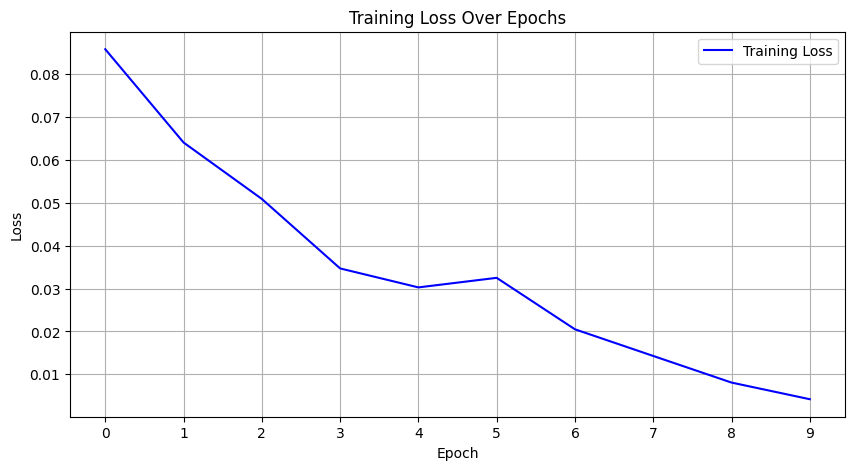

In [ ]:
# Plotting the training loss using Matplotlib
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss_values)), loss_values, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs for Baseline')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(len(loss_values)))
plt.grid()
plt.legend()
plt.show()

### Loading and preprocessing data

In [ ]:
# transformer for training data
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

# transformer for testing data - without data transformation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

# Loading the dataset from pytorch library
# Load the Falah/Alzheimer_MRI dataset
data_train = load_dataset('Falah/Alzheimer_MRI', split='train')
data_test = load_dataset('Falah/Alzheimer_MRI', split='test')

# Print the number of examples and the first few samples
print("Number of examples:", len(data_test))
print("Sample data:")
for example in data_test[:5]:
    print(example)


from PIL import Image


def transform_test_function(examples):
    # Apply transform_train to each image in the list
    # Convert each item in the 'image' list to a PIL Image before applying the transform
    # Fix: Access the file path string from the list before opening with Image.open
    examples['image'] = [transform_train(Image.open(image_path[0])) for image_path in examples['image']]
    return examples

def transform_train_function(examples):
    # Apply transform_test to each image in the list
    # Convert each item in the 'image' list to a PIL Image before applying the transform
    # Fix: Access the file path string from the list before opening with Image.open
    examples['image'] = [transform_test(Image.open(image_path[0])) for image_path in examples['image']]
    return examples

# Apply transformation to training and testing data
data_train = data_train.map(transform_train_function)
data_test = data_test.map(transform_test_function)
# Step 1: Select 10 images from the transformed training dataset
images_to_display = []
for i in range(10):
    # Assuming 'image' is the key for images in your dataset
    images_to_display.append(data_train[i]['image'])

lt.lovely(images_to_display)

### Evaluation old

По всем классам и по каждому классу:

    Precision
    Recall
    F1



Секция с результатами обучения должна содержать:

    График лосс-функции в процессе обучения
    График метрик на валидационной выборке во время обучения
    5-10 примеров изображений с результатом работы сети
    Значения метрик


In [ ]:
# Evaluation function to calculate precision, recall and F1 score
def evaluate(model):
    model.eval()  # Set the model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)  # Get predictions

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds_np = np.array(all_preds)
    all_labels_np = np.array(all_labels)

    precision_macro_avg = precision_score(all_labels_np, all_preds_np, average='macro')
    recall_macro_avg = recall_score(all_labels_np, all_preds_np, average='macro')
    f1_macro_avg = f1_score(all_labels_np, all_preds_np, average='macro')

    print(f'Macro Average Precision: {precision_macro_avg:.4f}')
    print(f'Macro Average Recall: {recall_macro_avg:.4f}')
    print(f'Macro Average F1 Score: {f1_macro_avg:.4f}')

    # Log evaluation metrics to W&B
    wandb.log({"Precision_macro": precision_macro_avg , "Recall_macro": recall_macro_avg , "F1_macro": f1_macro_avg})

    # Calculate per-class metrics
    precision_per_class = precision_score(all_labels_np, all_preds_np, average=None)
    recall_per_class = recall_score(all_labels_np, all_preds_np, average=None)
    f1_per_class = f1_score(all_labels_np, all_preds_np, average=None)

    #wandb.log({"Precision/class": precision_per_class , "Recall/class": recall_per_class , "F1/class": f1_per_class})

    return precision_macro_avg, recall_macro_avg, f1_macro_avg, precision_per_class, recall_per_class, f1_per_class



In [ ]:
# Evaluate the model
%%capture cap
precision_macro_avg, recall_macro_avg, f1_macro_avg, precision_per_class, recall_per_class, f1_per_class = evaluate(model)
wandb.finish()

NameError: name 'evaluate' is not defined

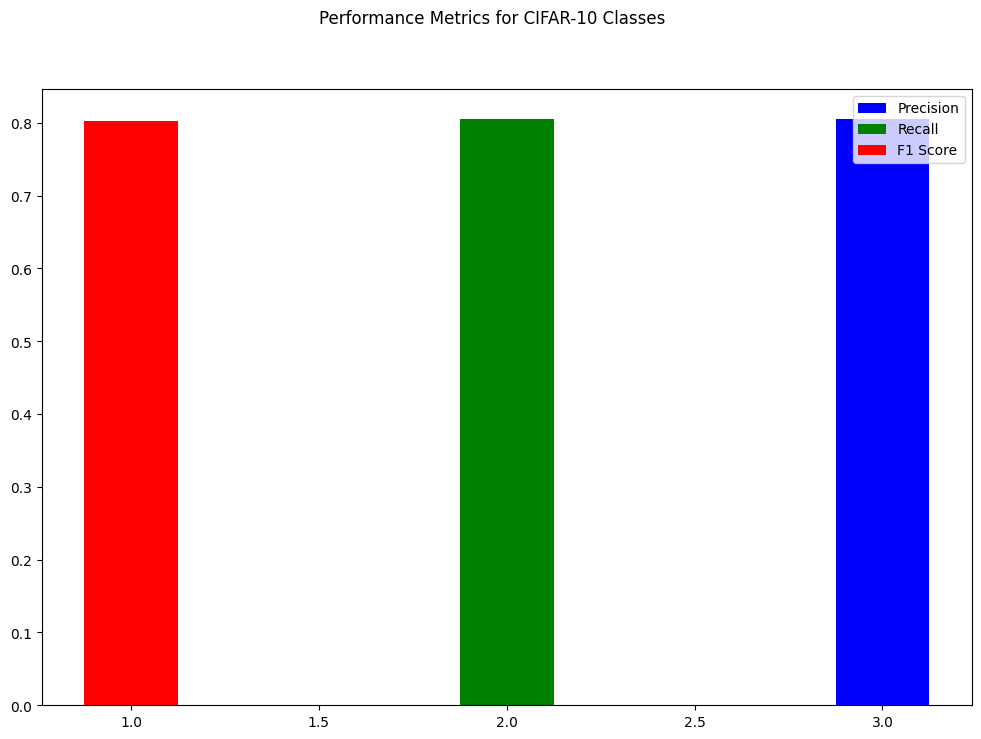

In [ ]:
plt.figure(figsize=(12, 8))

plt.bar(3, precision_macro_avg , width=0.25 , label='Precision' , color='b')
plt.bar(2, recall_macro_avg , width=0.25 , label='Recall' , color='g')
plt.bar(1, f1_macro_avg , width=0.25 , label='F1 Score' , color='r')

#plt.xticks(indices , classes_names )
plt.suptitle('Performance Metrics for baseline')
plt.legend()
plt.show()

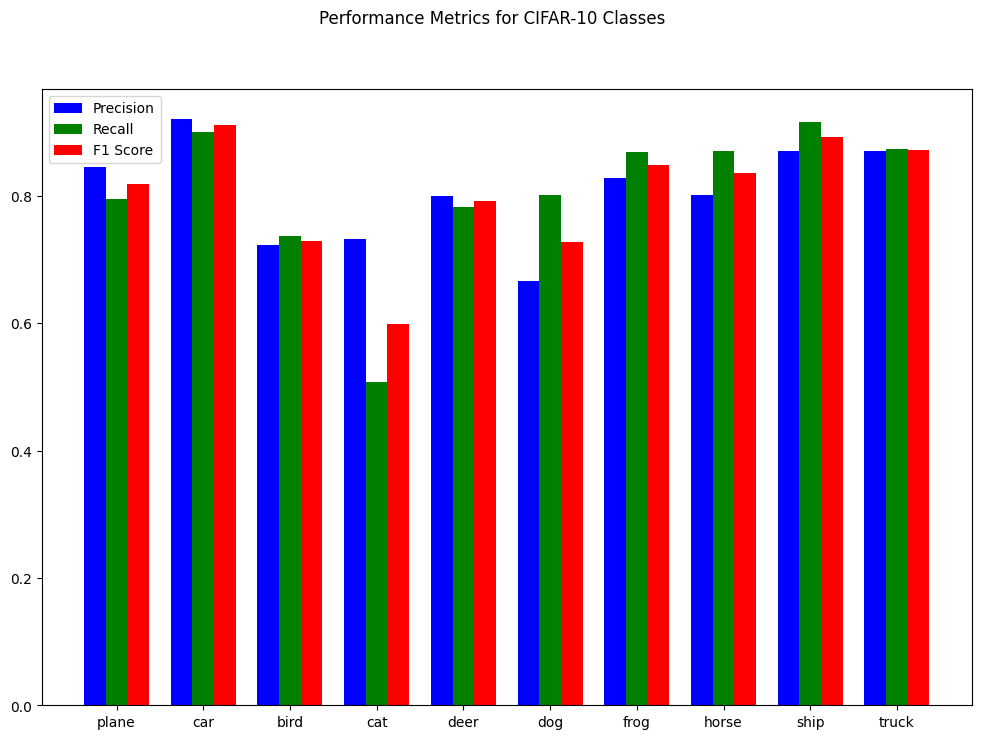

In [ ]:
# Visualization for classes
classes_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_metrics(names):
    indices = np.arange(len(names))

    plt.figure(figsize=(12, 8))

    plt.bar(indices - 0.25 , precision_per_class , width=0.25 , label='Precision' , color='b')
    plt.bar(indices , recall_per_class , width=0.25 , label='Recall' , color='g')
    plt.bar(indices + 0.25 , f1_per_class , width=0.25 , label='F1 Score' , color='r')

    plt.xticks(indices , classes_names )
    plt.suptitle('Performance Metrics for Classes (baseline)')
    plt.legend()
    plt.show()

plot_metrics(classes_names)

In [ ]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])